Groundwater | Case Study

# Topic 4 : From Concept to Code: Implementing the Limmat Valley Model

Dr. Xiang-Zhao Kong & Dr. Beatrice Marti & Louise Noël du Payrat

In [1]:
# Import libraries
# Import libraries
import sys
import os
import time
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union, linemerge
from shapely.affinity import rotate, translate, scale
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
import rasterio
from rasterio.warp import reproject, Resampling, transform_bounds
from rasterstats import zonal_stats


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import flopy
import flopy.plot as fpl
from flopy.discretization import StructuredGrid
from flopy.utils import Raster, GridIntersect

# Add the support repo to the path
sys.path.append('../SUPPORT_REPO/src')
sys.path.append('../SUPPORT_REPO/src/scripts/scripts_exercises')

# Import local modules
from data_utils import (
    download_named_file, 
    get_default_data_folder, 
    fast_resample_dem_to_modelgrid
)
from print_images import display_image
from progress_tracking import (
    create_model_implementation_progress_tracker, 
    create_nested_step_completion_marker, 
)
from grid_utils import build_grid_gdf_and_ibound
from river_utils import compute_medial_centerlines
from map_utils import plot_interactive_model_domain_3d

Starting search for project root from: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY
Marker file not found in /Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY. Moving up...
Checking path: /Users/bea/Documents/GitHub/applied_groundwater_modelling
Found project root: /Users/bea/Documents/GitHub/applied_groundwater_modelling (marker: config.py)
Loaded configuration from 'config.py'


In the previous steps, we defined our modeling objectives and developed a perceptual model of the Limmat Valley aquifer. We gathered data on the aquifer's geometry, its boundaries, and the key hydrological processes like recharge and river interaction.

Now, we will translate this perceptual understanding into a numerical groundwater model using **MODFLOW 2005** and the Python package **FloPy**. This means we describe the aquifer with numbers and grids, so a computer can simulate water movement. This process involves several key steps:

1.  **Discretization:** Defining the model grid (layers, rows, columns) that will represent our aquifer in space.
2.  **Parameterization:** Assigning hydraulic properties (like conductivity and storage) to the grid cells.
3.  **Boundary Conditions:** Implementing the physical boundaries of our system, such as rivers, recharge, and wells.
4.  **Solving:** Choosing a numerical solver and running the simulation.
5.  **Post-processing:** Visualizing and analyzing the initial results.

You can use the checklist below to keep track of your progress:

In [ ]:
create_model_implementation_progress_tracker()

## 1 Workspace Setup
Let's begin by setting up our model workspace. This involves creating a flopy workspace that we will fill with the model grid, boundary conditions, and other necessary components as we progress through the case study.

In [2]:
# Define the name of our model and the workspace where files will be stored.
# We'll create a directory in your default data folder for this course to keep 
# things organized. 
model_name = 'limmat_valley_model'
workspace = os.path.join(get_default_data_folder(), model_name)

# Create the workspace directory if it doesn't exist
os.makedirs(workspace, exist_ok=True)

# Define the path to the MODFLOW executable
# We assume it's in a standard location accessible from the system's PATH.
executable = 'mf2005' 

# Create the MODFLOW model object
# The model object is the main object in FloPy that represents the MODFLOW model.
# It manages all the information about the model, including the grid, boundary 
# conditions, and other settings.
# We'll fill it with the necessary components as we go along.
mf = flopy.modflow.Modflow(
    modelname=model_name, 
    model_ws=workspace, 
    exe_name=executable
)

In [ ]:
create_nested_step_completion_marker(1)

## 2 Discretization (DIS) Package
The DIS package defines the geometry and time discretization of a MODFLOW model. It tells MODFLOW how the model domain is divided into layers, rows, and columns, and how time is represented in stress periods.

Key inputs are:  
- Spatial discretization:  
    - nlay, nrow, ncol – number of layers, rows, and columns.  
    - delr, delc – cell sizes in the row and column directions.  
    - top – array of top elevations of the model domain.  
    - botm – arrays of bottom elevations for each layer.  
- Temporal discretization:  
    - nper – number of stress periods.  
    - perlen – length of each stress period.  
    - nstp – number of time steps per stress period.  
    - tsmult – time step multiplier (controls time-step progression).  
    - steady – flag indicating whether a period is steady-state or transient.  

The DIS package is the foundation of the model: all other packages (boundary conditions, hydraulic properties, solute transport) build on the grid and time discretization it defines.

### 2.1 Model Grid

The first step is to define the spatial domain of our model. Based on our perceptual model, we will create a single-layer model. A single-layer model is a 2D model. This 2D model can still represent thickness and vertical flows. For this reason, people sometimes call it quasi-3D or 2.5D. 

We choose a grid size of 50 meters by 50 meters to start with. This means that each grid cell will represent a 50m x 50m area in the real world. This is a compromise between detail and computational efficiency. It will not allow us to capture small-scale features, but it will provide a good overview of the aquifer's behavior. We can refine the grid later in the modelling process if needed and we can assess the impact of the model resolution on the results in the sensitivity analysis.

We start with an initial grid and then rotate it to align with the flow direction. This will help us reduce the number of model cells and speed up the model run time.

#### 2.1.1 Data processing: Build the model grid
This cell creates a simple, uniform structured grid aligned to the case-study boundary. It reads the boundary polygon, derives grid dimensions from a chosen cell size, and instantiates a FloPy `StructuredGrid` with a defined origin and an initial rotation (set to 0° here for a clean baseline). Use this as a starting point before refining rotation or replacing the dummy elevations.  

- Inputs: `boundary_path` (GeoPackage/GeoJSON), `cell_size` (m)
- Steps: (1) load boundary, (2) compute grid extent and `nrow`/`ncol`, (3) build uniform `delr`/`delc` and the grid,
- Outputs: `modelgrid` (FloPy `StructuredGrid`) with origin, CRS, and rotation set,

Note: Rotation is initially 0° to verify alignment. After inspection, update the angle (or use the rotation-iteration helper) and recompute the grid artifacts so downstream visualization, MODFLOW setup, and exports use the chosen rotation.

limmat_model_boundary.gpkg already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
limmat_model_boundary_readme.md already exists in /Users/bea/applied_groundwater_modelling_data/limmat/gis.
Rotation (angrot): 0.0
Extent (xmin, xmax, ymin, ymax): (2676732.1290222453, 2683132.1290222453, 1246740.0495282596, 1251390.0495282596)
nlay, nrow, ncol: 1 93 128
Cell size (delr mean, delc mean): 50.0 50.0


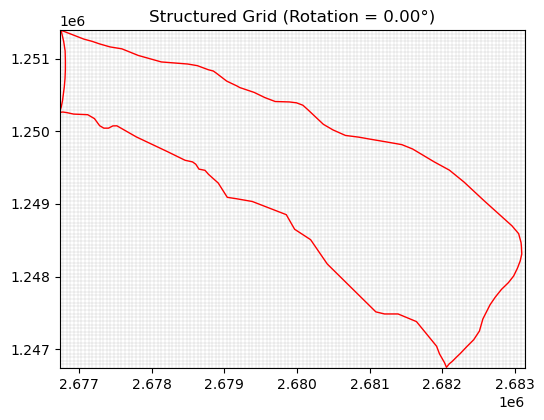

In [ ]:
# Inputs
boundary_path = download_named_file(name='model_boundary', data_type='gis')
cell_size = 50.0          # meters
rotation = 0.0            # degrees CCW (set e.g. 25.0 later)

# Read boundary
gdf = gpd.read_file(boundary_path)
if gdf.empty:
    raise ValueError("Model boundary file is empty.")
xmin, ymin, xmax, ymax = gdf.total_bounds

# Compute grid dimensions
width = xmax - xmin
height = ymax - ymin
ncol = int(np.ceil(width / cell_size))
nrow = int(np.ceil(height / cell_size))

delr = np.full(ncol, cell_size, dtype=float)
delc = np.full(nrow, cell_size, dtype=float)

# Vertical discretization (dummy for now)
nlay = 1
top = np.full((nrow, ncol), 100.0, dtype=float)  # Place holder
botm = np.full((nlay, nrow, ncol), 50.0, dtype=float)  # Place holder

# DIS rotation pivot = (xul, yul) = upper-left corner
xul = xmin
yul = ymax  # IMPORTANT: upper-left

# Create model grid
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xul=xul,
    yul=yul,
    rotation=rotation,  # degrees counter-clockwise
    lenuni=2,           # 2 = meters
    # Temporal discretization, place holders for now, we'll set this properly later
    nper=1,             # number of stress periods
    perlen=1.0,         # length of each stress period (days)
    nstp=1,             # number of time steps in each stress period
    tsmult=1.0,         # time step multiplier
    steady=True         # Steady-state simulation
)

print("Rotation (angrot):", mf.modelgrid.angrot)
print("Extent (xmin, xmax, ymin, ymax):", mf.modelgrid.extent)
print("nlay, nrow, ncol:", mf.dis.nlay, mf.dis.nrow, mf.dis.ncol)
print("Cell size (delr mean, delc mean):", delr.mean(), delc.mean())

# Quick plot for quality check
try:
    fig, ax = plt.subplots(figsize=(6, 6))
    pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, layer=0, ax=ax)
    pmv.plot_grid(alpha=0.4, linewidth=0.3)
    gdf.boundary.plot(ax=ax, color='red', linewidth=1)
    ax.set_title(f"Structured Grid (Rotation = {rotation:.2f}°)")
    ax.set_aspect("equal")
    plt.show()
except Exception as e:
    print("Grid plot skipped:", e)

Congratulation! You have successfully set up your first model grid and display it in Figure 1. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation.  

You will notice, that the main flow direction is diagonal to the cells orientation. There are a few reasons why this is sub-optimal: 

1. A diagonal flow direction can lead to *numerical dispersion* and other artifacts in the simulation results. As you might know from other lectures, the finite-difference method used in MODFLOW, calculates flow across the faces of the grid cells. It cannot directly compute flow diagonally across a single cell. Instead, it approximates a diagonal path as a series or orthogonal, "stair-step" movements from one cell to the next. We therefore try to allign the x-axis of the model grid along the main flow direction of a groundwater body. 
2. We also try to align the grid with major hydrogeological features and boundaries to avoid creating jagged, "stair-step" boundaries.
3. Because Modflow2005 only includes active model cells (inside the model boundary) in the simulation, the number of active model cells matters. It is the most important factor in the model design that determines the computational speed of the simulation. 

#### 2.1.3 Typically necessary iterations 
Creating a model grid is rarely a one-shot process. After the first attempt, visualization often reveals mismatches that require adjustment. Common iterations include:

- Rotation and alignment – adjusting the grid angle so that rows/columns follow the main axis of the model domain (e.g., a river valley).  
- Extent and origin – shifting or expanding the grid so the boundary fits cleanly within the grid cells.  
- Cell size – refining or coarsening resolution to balance accuracy with computational cost.

Such iterations are a normal part of model development. We visualize, adjust parameters, and regenerate the grid until it represents the case study domain well enough for the next steps. Here, we demonstrate one such iteration: rotating the grid to better align with the flow direction and buffering the model boundary to ensure full coverage.

##### Grid Rotation and Buffering
We rotate the model grid to align it with the model boundary. We will also buffer the model boundary to ensure that the grid cells cover the entire area of interest. The easiest way to do that are by following the steps below, each step is accompanied by visual checks: 
1. Rotate the model boundary polygon to align with the main flow direction and major hydrogeological features. 
2. Buffer the rotated model boundary polygon to ensure that the grid cells cover the entire area of interest.
3. Create a new grid based on the buffered polygon and apply the rotation to the structured grid.

We start with the rotation of the model boundary polygon. It should be rotated to minimize the number of grid cells outside the model boundary. Optimally, the grid cells should be aligned with the main flow direction.  

The rotation angle (variable `grid_rotation_angle` in code below) can be adjusted by trial and error to find the best fit.

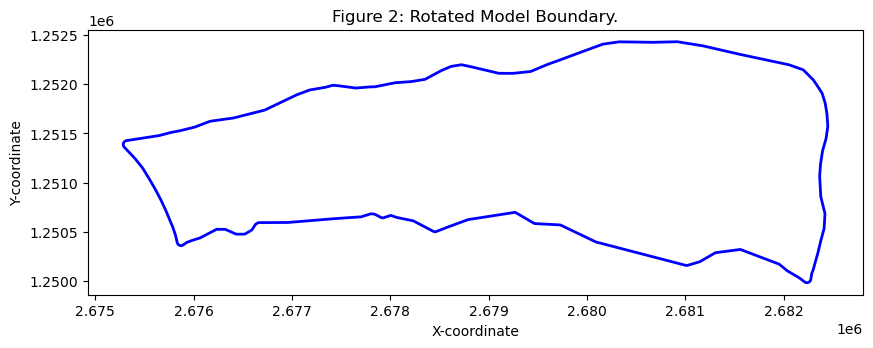

In [17]:
# --- 1. Rotation of the model boundary --- 
# To generate a rotated grid in FloPy, the easiest way is to create a regular 
# grid and then apply a rotation transformation to it. 
# We first rotate the model boundary polygon to the desired angle. From there, 
# we can create a regular grid and then apply the rotation to the grid in the 
# structured grid object.
# This approach allows us to maintain the integrity of the grid while applying
# the desired rotation.
# Every step includes visual checks.

# Buffer the model boundary gdf
gdf['geometry'] = gdf['geometry'].buffer(10)

# Define the rotation angle in degrees
grid_rotation_angle = 30  # degrees, identified by trial and error, you can adjust this angle to minimize the number of cells outside the boundary
origin_rotation = Point(xul, yul)  # Origin for rotation, upper left corner for consistency
# Rotate the model boundary polygon
gdf_rotated = gdf.copy()

gdf_rotated['geometry'] = gdf_rotated['geometry'].apply(
    lambda geom: rotate(geom, grid_rotation_angle, origin=origin_rotation)
)
# Get the bounding box of the rotated geometry
xmin_rotated, ymin_rotated, xmax_rotated, ymax_rotated = gdf_rotated.total_bounds
# Plot the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf_rotated.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2)
ax.set_title("Figure 2: Rotated Model Boundary.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

Figure 2 shows the rotated model boundary. An angle of 30 degrees seems to be suitable for the Limmat Valley model. In the next step, we will create a new grid based on this rotated model boundary (see Figure 3).

Original Grid: 128 columns, 93 rows
Rotated Grid: 143 columns, 50 rows


Text(0.5, 1.0, 'Figure 3: Rotated FloPy Grid with Rotated Boundary.')

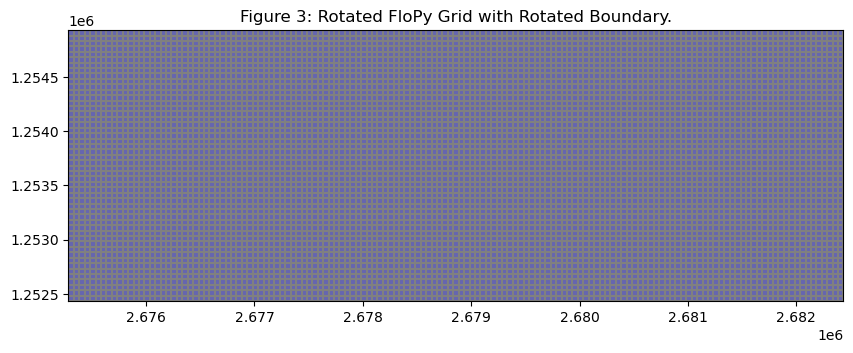

In [19]:
# --- 2. Creation of a new Model Grid based on the rotated Model Boundary ---
# We now have new bounding box coordinates for the rotated model boundary. 
# These we need to rotate back to the original coordinate system to create a
# regular grid that fits the rotated boundary.
# We use the rotated bounding box to define the grid dimensions.
# Calculate the new grid dimensions based on the rotated bounding box
width_rotated = xmax_rotated - xmin_rotated
height_rotated = ymax_rotated - ymin_rotated

# Calculate the number of rows and columns based on the rotated bounding box
ncol_rotated = int(np.ceil(width_rotated / cell_size)) - 1 # Based on visual inspection of rotated grid.
nrow_rotated = int(np.ceil(height_rotated / cell_size))

# Compare number of rows and columns with the original grid
print(f"Original Grid: {ncol} columns, {nrow} rows")
print(f"Rotated Grid: {ncol_rotated} columns, {nrow_rotated} rows")

# Define the delr and delc for the rotated grid
delr_rotated = np.full(ncol_rotated, cell_size)
delc_rotated = np.full(nrow_rotated, cell_size) 

# Plot the rotated grid and the rotated boundary to verify
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Create a new StructuredGrid with the rotated dimensions
rotated_grid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=np.ones((nrow_rotated, ncol_rotated)) * 100,  # Example top elevation
    botm=np.ones((nlay, nrow_rotated, ncol_rotated)) * 50,  # Example bottom elevation
    xoff=xmin_rotated,  # Use the lower-left of the rotated extent
    yoff=ymax_rotated,  # Use the lower-left of the rotated extent
    angrot=0,  # We are currently in the rotated coordinate system, so no additional rotation is needed
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf_rotated.crs.to_string()  # Automatically get CRS from geopackage
)
pmv = flopy.plot.PlotMapView(modelgrid=rotated_grid, ax=ax)
pc = pmv.plot_array(rotated_grid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio
ax.set_title("Figure 3: Rotated FloPy Grid with Rotated Boundary.")

Original coordinates after inverse rotation:
xmin: 2676041.97, ymin: 1250200.23
xmax: 2683418.34, ymax: 1248724.87
Corrected grid upper-left corner:
xul = 2676041.97
yul = 1248724.87
Number of cells in the rotated grid: 6958
Number of cells in the original grid: 11904
The rotated grid has 42 % less cells than the initial grid.


/Users/bea/anaconda3/envs/gw_course_students/lib/python3.12/site-packages/flopy/mbase.py:616: UserWarning: Unit 11 of package DIS already in use.
  warn(


Total number of active cells in the grid: 0
Model grid created with the following parameters:
xll:2674816.9676377624; yll:1246603.1069152588; rotation:-30; units:meters; lenuni:2


/Users/bea/Documents/GitHub/applied_groundwater_modelling/CASE_STUDY/../SUPPORT_REPO/src/grid_utils.py:66: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return gdf.geometry.unary_union


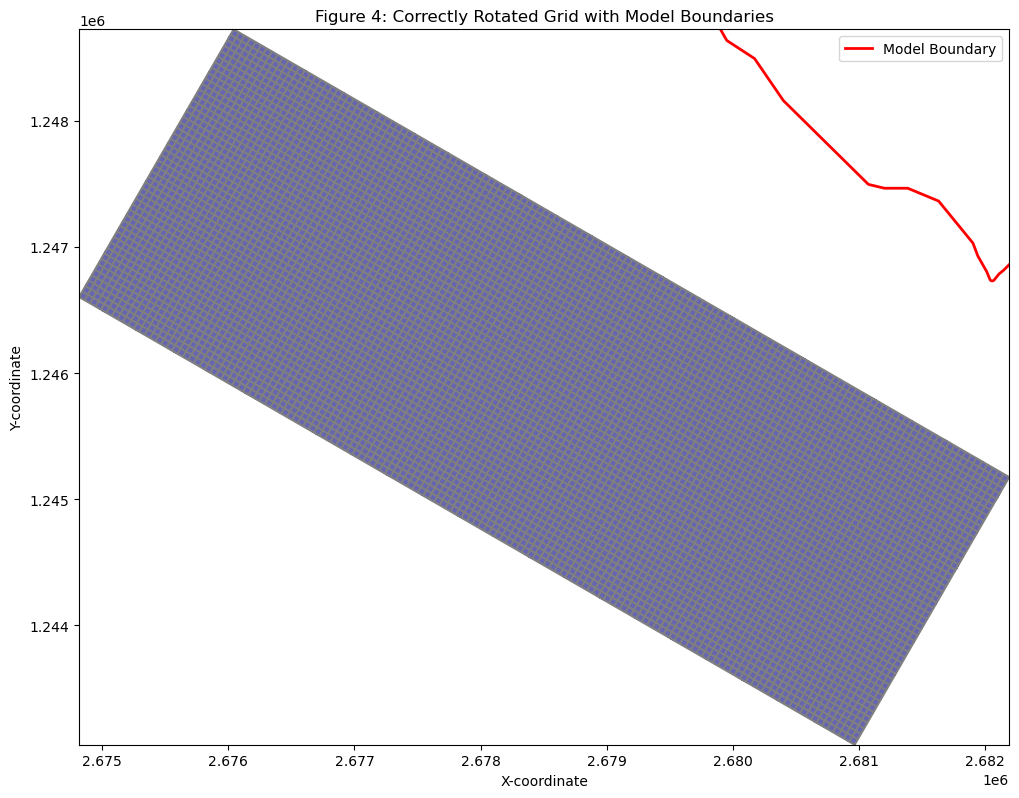

In [ ]:
# --- 3. Rotation of the new Model Grid in the CH Coordinate System ---
# Now we need to rotate the upper-left corner of the rotated grid back to the 
# original coordinate system.
# The upper-left corner of the rotated bounding box
# Create points from the rotated bounding box coordinates
min_point_rotated = Point(xmin_rotated, ymin_rotated)
max_point_rotated = Point(xmax_rotated, ymax_rotated)

# Apply inverse rotation (negative angle) around the same origin
min_point_original = rotate(min_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)
max_point_original = rotate(max_point_rotated, -grid_rotation_angle, 
                            origin=origin_rotation)

# Extract the coordinates
xmin_original = min_point_original.x
ymin_original = min_point_original.y
xmax_original = max_point_original.x
ymax_original = max_point_original.y

print(f"Original coordinates after inverse rotation:")
print(f"xmin: {xmin_original:.2f}, ymin: {ymin_original:.2f}")
print(f"xmax: {xmax_original:.2f}, ymax: {ymax_original:.2f}")

#xul = xmin_original
#yul = ymax_original

print(f"Corrected grid upper-left corner:")
print(f"xul = {xul:.2f}")
print(f"yul = {yul:.2f}")
print(f"Number of cells in the rotated grid: {nrow_rotated * ncol_rotated * nlay}")
print(f"Number of cells in the original grid: {nrow * ncol * nlay}")
print(f"The rotated grid has {round(((nrow * ncol * nlay) - (nrow_rotated * ncol_rotated * nlay))/(nrow * ncol * nlay)*100)} % less cells than the initial grid.")

# Update the top and bottom elevation arrays
# For simplicity, we keep the dummy elevations. They are reset later.
top = np.ones((nrow_rotated, ncol_rotated)) * 100  # Example top elevation
botm = np.ones((nlay, nrow_rotated, ncol_rotated)) * 50  # Example bottom elevation

# remove the old DIS package and create a new one with the updated parameters
if 'DIS' in mf.get_package_list():
    mf.remove_package('DIS')
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=top,
    botm=botm,
    xul=xul,
    yul=yul,
    rotation=-grid_rotation_angle,  # degrees counter-clockwise
    lenuni=2,           # 2 = meters
    # Temporal discretization, place holders for now, we'll set this properly later
    nper=1,             # number of stress periods
    perlen=1.0,         # length of each stress period (days)
    nstp=1,             # number of time steps in each stress period
    tsmult=1.0,         # time step multiplier
    steady=True         # Steady-state simulation
)

# Update grid polygons, tag active cells (≥50% inside), and get IBOUND
grid_gdf, ibound = build_grid_gdf_and_ibound(
    modelgrid=mf.modelgrid,
    boundary_gdf=gdf,        # your boundary GeoDataFrame
    frac_threshold=0.5,      # change if needed
    nlay=nlay                 # use your model's nlay
)
# Count the number of active cells
active_cells = ibound[ibound > 0].sum()
print(f"Total number of active cells in the grid: {active_cells}")

print("Model grid created with the following parameters:")
print(mf.modelgrid)

# Plot the rotated grid and the model_boundary to check alignment
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
pc = pmv.plot_array(mf.modelgrid.top, alpha=0.5, cmap='terrain')
pmv.plot_grid() 

gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line], loc='upper right')
ax.set_title("Figure 4: Correctly Rotated Grid with Model Boundaries")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()
ax.set_aspect('equal', adjustable='box') # Ensure correct aspect ratio

After rotating the grid, the number of cells increases slightly because the rotated extent no longer fits as tightly around the model boundary. We accept this trade-off, since aligning the grid with the main groundwater flow direction reduces numerical dispersion and improves the accuracy of simulated flow paths.

You might wonder why we care about numerical dispersion, given the large uncertainties involved in groundwater flow modelling. Even though groundwater flow models involve many uncertainties (hydraulic properties, recharge estimates, boundary conditions), we still want to minimize numerical errors such as numerical dispersion. The reason is simple: uncertainties are part of the real system and can be reduced with better data or calibration, but numerical errors are artificial and only come from how we discretize and solve the equations.

Numerical dispersion can smear sharp flow patterns, mix solutes unrealistically, or dampen hydraulic gradients. If we can reduce this error (e.g., by aligning the grid with the main flow direction), the model output better reflects the true hydrogeological processes, and we can focus on the real uncertainties that matter for decision-making.


#### 2.1.4 Save model grid for external use
Let's export the model grid to a shapefile in case we want to use it for visualizations outside flopy. Visualizing it in a different context, e.g. in QGIS, is a good sanity check. This will help us to verify that the grid is correctly aligned with the model boundary and that the cells are not too large or too small (see Figure 5).

In [ ]:
# Export the model grid to shapefile
# Create a list to store grid cell polygons
grid_cells = []

# Get grid cell vertices using FloPy's grid functionality
for i in range(modelgrid.nrow):
    for j in range(modelgrid.ncol):
        # Get cell vertices
        cell_vertices = modelgrid.get_cell_vertices(i, j)
        
        # Create polygon from vertices
        cell_polygon = Polygon(cell_vertices)
        
        # Store cell information
        grid_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': cell_polygon,
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })

# Create GeoDataFrame
grid_gdf = gpd.GeoDataFrame(grid_cells, crs=modelgrid.crs)

# Export to GeoPackage
grid_geopackage_path = os.path.join(workspace, 'model_grid.gpkg')
grid_gdf.to_file(grid_geopackage_path, driver='GPKG', layer='model_grid')

print(f"Model grid exported to: {grid_geopackage_path}")

In [ ]:
display_image(
    image_filename='model_grid_on_openstreetmap.png', 
    image_folder='4_model_implementation',
    caption='Figure 5: Model grid (grey) overlaid on OpenStreetMap background. The grid is rotated to minimize the number of cells while maintaining alignment with the model boundary (red). '
)

We now have a regular grid that fits the rotated boundary. The grid is defined by its origin, the number of rows and columns, and the cell size. The grid is a fundamental part of the model, as it defines the spatial resolution and extent of the simulation. 


> **Optional Challenge:**   
> Try to find a better rotation angle by adjusting the `grid_rotation_angle` variable in the code above. You can also try to change the `cell_size` to see how it affects the number of cells inside the model boundary.

In [ ]:
create_nested_step_completion_marker(2, 1)

### 2.2 Model Top
Now that we have the model grid, let's define the top of the model. The top of the model will be defined by the DEM, which we will use to create a single layer model. 

#### 2.2.1 Data processing: Resample DEM to model grid
We derive the model top elevation from the DEM. These are the steps to achieve this:

1. Resample the DEM to the model grid.
2. Extract the elevation values at the model grid locations.
3. Assign these values to the model top layer.

Let's have a look at our DEM in the model area (Figure 6). 

In [ ]:
# --- 1. Inspect the DEM ---
# Get the DEM data from the server
dem_path = download_named_file(
    name='dem',
    data_type='gis'
)

# Load it into object rio
rio = Raster.load(dem_path)

# Get the DEM array and its valid index
arr = rio.get_array(1)
idx = np.isfinite(arr)

# Get the min and max values for plotting
vmin, vmax = arr[idx].min(), arr[idx].max()

# Plot the DEM
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax = rio.plot(ax=ax, vmin=vmin, vmax=vmax)
plt.colorbar(ax.images[0], shrink=0.7)
# pmv.plot_grid(ax=ax, lw=0.5, color="white")
ax.set_title("Figure 6: DEM in original resolution in the model area.")


The resolution of the DEM does not match the model grid resolution, so we will resample the DEM to fit the model grid. We will use the `rio.resample_to_grid` function to resample the DEM to the model grid resolution. This will create a new raster that matches the model grid resolution and can be used as the model top (Figure 7).

In [ ]:
# --- 2. Resample the DEM ---
# Depending on the resolution of the DEM, resampling can be computationally 
# intensive.
t0 = time.time() # To log the time it takes to resample the DEM
model_top = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# We round to 10 centimeters to avoid having to store too many digits
model_top = np.round(model_top, 1)

# Update vmin and vmax based on the resampled data
vmin, vmax = model_top.min(), model_top.max()

# Now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_top, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)

# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 7: Resampled DEM on Model Grid with Buffered Model Boundary")

In [ ]:
# (Optional) Save the model top layer to a file for later use
# This step makes sense if resampling is slow. Instead of repeating the 
# resampling every time you run the notebook, you can just load the
# precomputed file.
top_file_path = os.path.join(workspace, 'model_top.npy')
np.save(top_file_path, model_top)

In [ ]:
create_nested_step_completion_marker(2, 2)

### 2.3 Model Bottom

Next we tackle the bottom layer. The groundwater map of the canton of Zurich shows contour lines of the thickness of the aquifer for the deeper zones but for the shallower zones we see the range of the aquifer thickness. We calculate the bottom of the model by subtracting the aquifer thickness from the model top. 

$$ \text{Bottom of the model} = \text{Top of the model} - \text{Aquifer thickness}$$

We'll walk you through the steps to create the bottom layer of the model in the following code cells.

#### 2.3.1 Data processing: Interpolate aquifer thickness to model grid
We'll start by displaying the contours of aquifer thickness in the model area (Figure 8). This will help us visualize the aquifer thickness and understand how it varies across the model area. Please note that the aquifer thickness is very thin in parts of the model area. Cells in this region may run dry during the simulation, which is a common occurrence in groundwater models of shallow unconfined aquifers. By default, cells that run dry become impermeable in modflow but we can set rewetting parameters which allow the model to iteratively re-activate dry cells. This can, however, lead to numerical instability. We'll have to keep an eye on this during the simulation and adjust the model parameters for re-wetting if necessary. 

A summary of the steps:
1. Visualize the aquifer thickness contours.
2. Interpolate the aquifer thickness to the model grid.
3. Subtract the aquifer thickness from the model top to obtain the model bottom.

In [ ]:
# --- 1. Visualize available aquifer bottom data ---
# Load the polygon layers with information about aquifer thickness.
gw_map_path = download_named_file(
    name='groundwater_map_norm', 
    data_type='gis', 
)

deep_contours_gdf = gpd.read_file(gw_map_path, layer="GS_GW_MAECHTIGKEIT_L")
shallow_gdf = gpd.read_file(gw_map_path, layer="GS_GW_LEITER_F") 

# Reproject the GeoDataFrames to match the model grid CRS
deep_contours_gdf = deep_contours_gdf.to_crs(modelgrid.crs)
shallow_gdf = shallow_gdf.to_crs(modelgrid.crs)

# For the deep contours, the aquifer thickness in meters is in the field 
# "LABEL". For the shallow contours, we have the field "GWLTYP" which corresponds 
# to a range of aquifer thickness. We have to manually assign a label attribute 
# here, using the GIS-Broswer as reference. 
# type_labels maps GWLTYP to the corresponding aquifer thickness in meters.
type_labels = {
        1: 2, 
        2: 2,
        4: 10,
        6: 20,
    }
# Create a new column 'aquifer_thickness' in shallow_gdf
shallow_gdf['aquifer_thickness'] = shallow_gdf['GWLTYP'].map(type_labels)

# Create a new column 'aquifer_thickness' in deep_contours_gdf
deep_contours_gdf['aquifer_thickness'] = deep_contours_gdf['LABEL'].astype(float)

# Discard rows in the shallow_gdf where aquifer_thickness is NaN
shallow_gdf = shallow_gdf.dropna(subset=['aquifer_thickness'])

# Now we need to make sure all shapes are available as lines. 
# Convert shallow polygons to contour lines by taking their boundaries
shallow_contours_gdf = shallow_gdf.copy()
shallow_contours_gdf.geometry = shallow_contours_gdf.geometry.boundary

# Define the buffered model boundary as a contour with 5m thickness (2 meters 
# is very shallow and will quickly lead to cells drying).
boundary_contour_gdf = gdf.copy()
boundary_contour_gdf['aquifer_thickness'] = 5.0

# View the first few rows of the deep contours and shallow contours
# print("Deep contours (aquifer thickness in meters):")
# print(deep_contours_gdf[['LABEL', 'aquifer_thickness']].head())
# print("\nShallow contours (aquifer thickness in meters):")
# print(shallow_gdf[['GWLTYP', 'aquifer_thickness']].head())

# Combine all contour dataframes into one
# We select only the 'aquifer_thickness' and 'geometry' columns to ensure consistency
all_contours_gdf = gpd.GeoDataFrame(
    pd.concat([
        deep_contours_gdf[['aquifer_thickness', 'geometry']],
        shallow_contours_gdf[['aquifer_thickness', 'geometry']],
        boundary_contour_gdf[['aquifer_thickness', 'geometry']]
    ], ignore_index=True),
    crs=gdf.crs
)

# Clip the contours to the model boundary polygon
clipped_gdf = gpd.clip(all_contours_gdf, gdf)

# Now we can plot the combined contours
fig, ax = plt.subplots(figsize=(12, 12))
clipped_gdf.plot(ax=ax, column='aquifer_thickness', cmap='viridis',
                 legend=True, legend_kwds={'label': "Aquifer Thickness (m)"})
ax.set_title("Figure 8: Contours of aquifer thickness in the model area.")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
plt.show()

Now we need to subtract the aquifer thickness from the top of the model to define the bottom of the model. 

For this, we interpolate the contour lines of the aquifer thickness to the model grid (Figure 9). This will create a new raster that matches the model grid resolution which we can subtract from the top of the model to obtain the bottom elevation (Figure 10).

In [ ]:
# --- 2. Interpolate the aquifer thickness on the model grid and calculate 
# aquifer thickness

# ---    Interpolate aquifer thickness to model grid ---
# Extract all points from the combined contour lines for interpolation
points_for_interp = []
for idx, row in clipped_gdf.iterrows():
    if row.geometry is None or row.geometry.is_empty:
        continue
    if row.geometry.geom_type == 'MultiLineString':
        for line in row.geometry.geoms:
            for x, y in line.coords:
                points_for_interp.append((x, y, row['aquifer_thickness']))
    elif row.geometry.geom_type == 'LineString':
        for x, y in row.geometry.coords:
            points_for_interp.append((x, y, row['aquifer_thickness']))

points_for_interp = np.array(points_for_interp)

# --- PLOT: Points for Interpolation of Aquifer Thickness on Model Grid ---
# Uncomment the following lines to visualize the points used for interpolation
# fig, ax = plt.subplots(figsize=(12, 12))
# sc = ax.scatter(points_for_interp[:, 0], points_for_interp[:, 1], c=points_for_interp[:, 2], cmap='viridis', s=5)
# plt.colorbar(sc, label='Aquifer Thickness (m)')
# ax.set_title("Step 1. Points from All Contours for Interpolation")
# ax.set_xlabel("X-coordinate")
# ax.set_ylabel("Y-coordinate")
# ax.set_aspect('equal', adjustable='box')
# plt.show()

# Interpolate directly onto the model grid cell centers
grid_x, grid_y = modelgrid.xcellcenters, modelgrid.ycellcenters

# First, use linear interpolation. This creates a smooth surface between contours.
aquifer_thickness_linear = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x, grid_y), 
    method='linear'
)

# Linear interpolation leaves NaNs outside the convex hull of the data.
# Second, fill these NaNs using nearest neighbor interpolation to cover the whole grid.
nan_indices = np.isnan(aquifer_thickness_linear)
aquifer_thickness_resampled = griddata(
    points_for_interp[:, :2], 
    points_for_interp[:, 2],
    (grid_x[nan_indices], grid_y[nan_indices]), 
    method='nearest'
)
aquifer_thickness_linear[nan_indices] = aquifer_thickness_resampled

# The final resampled grid
aquifer_thickness_resampled = aquifer_thickness_linear

# Save aquifer thickness to a file for later use
aquifer_thickness_file_path = os.path.join(workspace, 'aquifer_thickness.npy')
np.save(aquifer_thickness_file_path, aquifer_thickness_resampled)

# --- PLOT: Resampled Grid on Model Grid ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(aquifer_thickness_resampled)
plt.colorbar(im, shrink=0.7, label="Aquifer Thickness (m)")
ax.set_title("Figure 9: Aquifer thickness resampled to model grid.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
plt.show()

# --- 3. Calculate the aquifer bottom ---
# Subtract the aquifer thickness from the top of the model to define the bottom
model_bottom = model_top - aquifer_thickness_resampled

# Ensure the model bottom is a 3d array (nlay, nrow_rotated, ncol_rotated)
if model_bottom.ndim == 2:
    model_bottom = model_bottom[np.newaxis, :, :]  # Add a new axis for layers

# --- PLOT: Final Aquifer Bottom ---
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_bottom, vmin=np.nanmin(model_bottom), 
                    vmax=np.nanmax(model_bottom))
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
ax.set_title("Figure 10: Final aquifer bottom elevation. ")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 10: Resampled DEM on Model Grid with Buffered Model Boundary")

plt.show()

#### 2.3.2 Visual check of updated model grid
Now we update the structured grid object by replacing the dummy model top in the model object with our resampled DEM. This will ensure that the model top reflects the actual topography of the Limmat Valley. We visualize the final model grid with the top elevation (Figure 11) for verification.  

In [ ]:
# Add new model top and bottom to the modelgrid
modelgrid = StructuredGrid(
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    nlay=nlay,
    xoff=xmin_original, # Use the lower-left of the rotated extent
    yoff=ymin_original, # Use the lower-left of the rotated extent
    angrot=-grid_rotation_angle, # Apply the desired rotation to the grid
    lenuni=2,  # Length unit code: 2 for meters
    crs=gdf.crs.to_string() # Automatically get CRS from geopackage
)

# Update the modelgrid in the MODFLOW model
mf.modelgrid = modelgrid

# Plot the mf modelgrid to verify
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(mf.modelgrid.botm, vmin=np.nanmin(mf.modelgrid.botm), 
                    vmax=np.nanmax(mf.modelgrid.botm), cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Bottom Elevation (m a.s.l.)")
pmv.plot_grid()
# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])

ax.set_aspect('equal', adjustable='box')
ax.set_title("Figure 11: Final Model Grid with Bottom Elevation.")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.show()

In [ ]:
create_nested_step_completion_marker(2, 3)

#### 2.4 Write the model geometry to DIS package
Finally we save the model grid to the DIS package of our model. Please note that when defining the DIS package, we can also pass the temporal discretization parameters directly to the DIS package constructor (see code snippet below). We will start out with a steady state simulation, so we only need one stress period. If you have transient data, you would define multiple stress periods. 

In [ ]:
# Temporal discretization
# We start out with a steady state simulation, so we only need one stress period.
# If you have transient data, you would define multiple stress periods.
# Here, we define a single stress period with a length of 1 day.
# Please note that we hereby implicitly define the time unit of our model to be 
# days. We will need to be consistent with this throughout the model setup. 
nper = 1  # Number of stress periods
perlen = [1.0]  # Length of each stress period in days
nstp = [1.0]  # Number of time steps in each stress period (defaults to 1 for steady state) 
tsmult = [1.0]  # Time step multiplier (only used in transient simulations)
steady = [True]  # Steady state flag for each stress period

# Explicitly pass the grid parameters to the DIS package constructor.
# This will correctly set the nrow, ncol, etc. on the mf object.
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top,
    botm=model_bottom,
    xoff=xmin_original,
    yoff=ymin_original,
    angrot=-grid_rotation_angle,
    lenuni=2,
    crs=gdf.crs.to_string(),  # Automatically get CRS from geopackage
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady
)

# Save the model grid to a file for later use
grid_file_path = os.path.join(workspace, 'model_grid.pkl')
with open(grid_file_path, 'wb') as f:
    pickle.dump(modelgrid, f) 

In [ ]:
create_nested_step_completion_marker(2, 4)

## 3 Parameterization
The discretized groundwater flow equation contains several parameters that need to be defined for the model. We will simplify the zonation described by Doppler and colleagues [\[1\]](#References). For this, we have defined zones of equal hydraulic conductivities in QGIS (See Figure 12). The paramter field is then saved to our model using the layer-property flow package.

In [ ]:
display_image(
    image_filename='parameters_zonation.png', 
    image_folder='4_model_implementation',
    caption="Figure 12: Left: Zonation of hydraulic conductivities by Doppler and colleagues (roman numbers I to VI). Right: Simplified zonation of hydraulic conductivities in 2 zones (green, downstream & yellow, upstream) in the present study."
)

### 3.1 Layer-Property Flow (LPF) Package

The Layer-Property Flow (LPF) Package is where we specify the hydraulic properties of the aquifer. These properties determine how easily water moves through the subsurface and how the aquifer stores and releases water.

- **Hydraulic Conductivity (K)**: Since we don’t have site-specific measurements, we will begin with a uniform value of 10 m/d, which is typical for gravel aquifers (see Notebook 2). Later, during model calibration, we may divide the model into zones with different values of K to better represent aquifer heterogeneity.  
- **Storage Properties**: For this first version of the model, we assume uniform values:
    - Specific storage (Ss): $1 \times 10^{-4} \, \text{m}^{-1}$ (represents elastic storage, important in confined conditions).  
    - Specific yield (Sy): 0.15 (represents drainable porosity, dominant in unconfined conditions).  
- **Hydraulic Conductivity Field**: With these settings, the model currently uses a single uniform conductivity field (Figure 13).  
- **Wetting Parameters**: The LPF package also contains options for wetting parameters, which control how model cells that become dry can re-wet during transient simulations. For simple steady-state or basic transient models these are not strictly necessary, but they become important in more advanced models that include significant water table fluctuations.  

In [ ]:
import numpy as np
import geopandas as gpd
from flopy.utils.gridintersect import GridIntersect

# Assign hydraulic conductivity (hk) from polygon zones to a MODFLOW-2005 StructuredGrid (LPF)
# - Uses parameter_zones polygons
# - Applies uniform hk per zone across all layers
# - Does NOT modify ibound

# 1. Load zones
zones_file = download_named_file('parameter_zones', data_type='limmat_valley_model')
zones = gpd.read_file(zones_file)
if zones.empty:
    raise ValueError("parameter_zones dataset contains no features.")

# 2. Ensure a zone identifier column
zone_col = None
for c in zones.columns:
    if c.lower() in {"zone", "zones", "zone_id", "id"}:
        zone_col = c
        break
if zone_col is None:
    zones = zones.copy()
    zone_col = "zone"
    zones[zone_col] = np.arange(1, len(zones) + 1)

# 3. Zone → hk mapping (m/day). Adjust as needed.
hk_map = {
    1: 50.0,
    2: 5.0,
}
background_hk = 0.0  # hk for cells not covered by specified zones

# 4. Prepare hk array
nlay, nrow, ncol = mf.dis.nlay, mf.dis.nrow, mf.dis.ncol
hk_array = np.full((nlay, nrow, ncol), background_hk, dtype=float)

# 5. Intersection helper
grid = mf.modelgrid
gx = GridIntersect(grid, method="vertex")

# 6. Assign hk values
touched = set()
for _, r in zones.iterrows():
    geom = r.geometry
    if geom is None or geom.is_empty:
        continue
    zid = r[zone_col]
    if zid not in hk_map:
        continue
    res = gx.intersect(geom)
    if len(res) == 0:
        continue
    for (i, j) in res["cellids"]:
        hk_array[:, i, j] = hk_map[zid]
        touched.add((i, j))

# 7. Attach/update LPF
if hasattr(mf, "lpf") and mf.lpf is not None:
    mf.lpf.hk = hk_array
else:
    import flopy
    flopy.modflow.ModflowLpf(mf, hk=hk_array, vka=hk_array/10.0)

# 8. Summary
print("hk assignment complete")
print(f"hk shape: {hk_array.shape}")
print(f"Zones column: {zone_col}")
print(f"Horizontal cells touched: {len(touched)} ({len(touched)/(nrow*ncol)*100:.1f}%)")
print("Zone → hk mapping:")
for k, v in hk_map.items():
    print(f"  {k}: {v} m/day")
print(f"Background hk: {background_hk} m/day")

# Test that all hk values are reasonable
hk_full = np.array(mf.lpf.hk.array)  # ensure concrete ndarray
print("hk_full shape:", hk_full.shape)
print("Layer0 min/max/unique count:",
      float(np.nanmin(hk_full[0])), float(np.nanmax(hk_full[0])),
      len(np.unique(hk_full[0])))

nz = np.count_nonzero(hk_full[0])
print("Non‑zero cells layer 0:", nz)
if nz == 0:
    raise ValueError("All hk values are zero in layer 0.")

# 9. Optional quick plot (layer 1)
layer0 = mf.lpf.hk.array[0].astype(float)
masked = np.ma.masked_equal(layer0, 0.0)

cmap = plt.cm.viridis.copy()
cmap.set_bad(alpha=0)   # masked -> transparent

fig, ax = plt.subplots(figsize=(7,6))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
im = pmv.plot_array(masked)
pmv.plot_grid(alpha=0.25, linewidth=0.3)
plt.colorbar(im, ax=ax, shrink=0.75, label="hk (m/day)")
ax.set_title("Hydraulic Conductivity (Layer 1)")
ax.set_aspect("equal")
plt.show()


In [ ]:
print("Model angrot (deg):", getattr(mf.modelgrid, "angrot", None))
print("Grid extent:", mf.modelgrid.extent)
print("First 3 cell centers x:", mf.modelgrid.xcellcenters[0,:3])
print("First 3 cell centers y:", mf.modelgrid.ycellcenters[:3,0])
print("Zones bounds:", zones.total_bounds)

# Quick overlay
import matplotlib.pyplot as plt
from flopy.plot import PlotMapView
layer0 = np.array(mf.lpf.hk.array)[0]
fig, ax = plt.subplots(figsize=(6,6))
pmv = PlotMapView(modelgrid=mf.modelgrid, layer=0, ax=ax)
im = pmv.plot_array(layer0, cmap="viridis")
zones.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
pmv.plot_grid(alpha=0.25, linewidth=0.3)
plt.colorbar(im, ax=ax, shrink=0.75)
ax.set_aspect("equal")
plt.show()

In [ ]:
# Uniform hydraulic conductivity values
# Typical for sandy gravel aquifers in Swiss valleys
hk_uniform = 10.0  # m/day - horizontal hydraulic conductivity
vk_uniform = 1.0   # m/day - vertical hydraulic conductivity (typically Kh/10)

# Create uniform K arrays
hk = np.ones((nlay, nrow_rotated, ncol_rotated)) * hk_uniform
vk = np.ones((nlay, nrow_rotated, ncol_rotated)) * vk_uniform

# Storage properties (uniform)
sy = 0.15  # Specific yield (typical for unconfined sandy gravel aquifers)
ss = 1e-4  # Specific storage (1/m) (typical value)

# Layer type (0 = confined, 1 = convertible/unconfined)
# Limmat valley aquifer is unconfined
laytyp = 1

# Create the LPF package
lpf = flopy.modflow.ModflowLpf(
    mf,
    hk=hk,                  # Horizontal hydraulic conductivity
    vka=vk,                 # Vertical hydraulic conductivity
    sy=sy,                  # Specific yield
    ss=ss,                  # Specific storage
    laytyp=laytyp,          # Layer type (1 = convertible/unconfined)
    ipakcb=53,              # Unit number for cell-by-cell budget file
    hdry=-999.99,           # Head assigned to dry cells
    wetfct=0.2,             # Wetting factor
    iwetit=2,               # Wetting iteration interval (outer iteration)
    laywet=1,                # Flag indicating if wetting is active for each layer
    wetdry=0.01              # Threshold for wetting (fraction of cell thickness)
)

print("\nLPF package created successfully with uniform properties:")
print(f"Horizontal hydraulic conductivity: {hk_uniform} m/day")
print(f"Vertical hydraulic conductivity: {vk_uniform} m/day")
print(f"Specific yield: {sy}")
print(f"Specific storage: {ss} 1/m")
print(f"Layer type: {'Convertible (unconfined)' if laytyp == 1 else 'Confined'}")

# Quick visualization of the uniform K field
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

# Plot horizontal K
pmv1 = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax1)
im1 = pmv1.plot_array(hk[0], masked_values=[0])
#pmv1.plot_inactive(ibound[0], color='gray', alpha=0.8)
pmv1.plot_grid(alpha=0.3, linewidth=0.5)
gdf.plot(ax=ax1, facecolor='none', edgecolor='red', linewidth=2)
cb1 = plt.colorbar(im1, ax=ax1, shrink=0.7)
cb1.set_label("Horizontal K (m/day)")
ax1.set_title(f"Figure 13: Initial horizontal hydraulic conductivity (uniform = {hk_uniform} m/day)")
ax1.set_xlabel("X-coordinate (m)")
ax1.set_ylabel("Y-coordinate (m)")
ax1.set_aspect('equal')

plt.tight_layout()
plt.show()

# Save the uniform K field for reference
np.save(os.path.join(workspace, 'uniform_hk_field.npy'), hk)
np.save(os.path.join(workspace, 'uniform_vk_field.npy'), vk)
print(f"\nUniform K fields saved to {workspace}")

### 3.2 A note on assigning Parameter Fields
A good first step is to assign uniform parameter values (e.g., a single hydraulic conductivity and storage value for the entire model domain) to keep the system simple and transparent. In reality, aquifer properties are heterogeneous, but beginning with uniform fields helps isolate structural issues before adding complexity. The modeler can then progressively introduce spatial variability and adjust parameter values to improve water balance closure and calibration performance. This staged approach reduces ambiguity and supports defensible model development. The following list shows you increasingly sophisticated methodologies to refine parameter fields: 
 
- Zonation – divide the model into regions (zones) where each zone has its own parameter value (e.g., sand vs. clay areas).

- Interpolation (e.g., kriging, IDW) – use point measurements (e.g., from wells) to interpolate continuous parameter fields across the model grid.

- Geostatistical/simulation methods – generate stochastic parameter fields that honor both measurements and spatial variability.

- Pilot points / parameter estimation – assign parameters at selected control points and let calibration tools adjust them to fit observed data.

👉 The choice depends on data availability, model purpose, and computational cost. For teaching, we start simple with uniform values, and later explore how to refine parameter distributions.

In [ ]:
create_nested_step_completion_marker(3)

## 4 Boundary & Initial Conditions
Now that we have the model geometry and parameterization defined, we need to establish the boundary and initial conditions for the simulation. These correspond to the arrows in the perceptual model figure we discussed in Notebook 2, describing fluxes in and out of the model. 

### 4.1 Active Cells - Basic Package (BAS) 

The BAS package has the following responsibilities: 
- *Initial heads*: Starting conditions for the solver.
- *IBOUND array*: Defines the active/inactive status of each cell.
    - IBOUND > 0: Active cell
    - IBOUND = 0: Inactive cell
    - IBOUND < 0: Fixed-head cell

We'll assume all cells within the aquifer boundary are active and that the initial head lies at 1 meter below the ground surface. 

Please follow the steps in the code cell below to create the Basic Package.

#### 4.1.1 Identify Active Cells
Modflow only solves the flow equation for active cells (IBOUND > 0). We need to create the IBOUND array based on the active cells identified in the model grid.

In [ ]:
# --- 1. Data processing ---
# Goal: Create IBOUND array to define active/inactive cells
# Note: Active cells (1) are inside the model boundary, inactive cells (0) are 
# outside
# Steps: 
# 1. Create an empty IBOUND array with all cells inactive (0)
# 2. Use the original model boundary (not buffered) for IBOUND
# 3. Assign active cells (1) based on the intersection with the boundary

# Initialize IBOUND array with all cells inactive (0)
ibound = np.zeros((nlay, nrow_rotated, ncol_rotated), dtype=int)

# Using GridIntersect (recommended for complex boundaries and rotated grids)
# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Get the intersection between the grid and the boundary polygon
# This returns the cells that intersect with the polygon
try:
    result = ix.intersect(gdf.geometry.union_all())
    
    # Extract the row and column indices of cells inside the boundary
    for idx, row in result.iterrows():
        ibound[0, row['row'], row['col']] = 1
        
    print("Successfully created IBOUND using GridIntersect method")
    
except Exception as e:
    print(f"GridIntersect method failed: {e}")
    print("Falling back to cell center method...")
    
    # Fallback Method: Using cell centers
    # Get cell centers
    xcenters = modelgrid.xcellcenters
    ycenters = modelgrid.ycellcenters
    
    # Get the boundary polygon
    boundary_polygon = gdf.geometry.union_all()
    
    # Check which cell centers are inside the boundary polygon
    for i in range(nrow_rotated):
        for j in range(ncol_rotated):
            point = Point(xcenters[i, j], ycenters[i, j])
            if boundary_polygon.contains(point):
                ibound[0, i, j] = 1

# Count active and inactive cells
active_cells = np.sum(ibound == 1)
inactive_cells = np.sum(ibound == 0)
print(f"\nInitial IBOUND statistics:")
print(f"Active cells: {active_cells}")
print(f"Inactive cells: {inactive_cells}")
print(f"Total cells: {active_cells + inactive_cells}")
print(f"Percentage active: {active_cells / (active_cells + inactive_cells) * 100:.1f}%")


#### 4.1.2 Visualize IBOUND Array
We visually check if the IBOUND array correctly represents the model domain by overlaying it on the aquifer thickness map.

In [ ]:
# --- 2. Visualization of IBOUND ---
# Plot IBOUND array with custom colormap
# Define discrete colormap: order must match categories [-1, 0, 1]
# Colors: CHD = orange, Inactive = white, Active = blue
cmap = mcolors.ListedColormap([
    "#1f77b4",  # -1 CHD
    "#111111",  # 0 inactive
    "#ffffff"   # 1 active
])
# Boundaries define bins for the 3 categories
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(ibound[0], cmap=cmap, norm=norm)

pmv.plot_grid(alpha=0.3, linewidth=0.5)

# Overlay the original boundary for verification
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

# Colorbar with custom ticks & labels
cbar = plt.colorbar(im, ax=ax, shrink=0.7, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["CHD (-1) (yet to be defined)", "Inactive (0)", "Active (1)"])
cbar.set_label("IBOUND code")

ax.set_title(f"Figure 12: IBOUND array displaying active (white) and inactive (black) cells.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')

# Create custom legend handles to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.legend(handles=[red_line])

plt.show()

We will write the IBOUND array once we have defined the constant head boundaries. 

#### 4.1.5 Identify Constant Head Cells
Oh, but we are not done yet! In MODFLOW, we have to assign IBOUND=-1 to the outflow cells along the western boundary.

The most straight forward way to select the cells with constant head is to load the IBOUND shape in QGIS and select the cells along the western boundary. See printscreen of QGIS in Figure 14. The selected features can then be exported as a shapefile and loaded into the notebook. The code below shows how to create the constant head boundary condition based on the selected cells.


In [ ]:
display_image(
    image_filename='selection_of_cells_for_chd_boundary_qgis.png', 
    image_folder='4_model_implementation',
    caption='Figure 14: Active cells of IBOUND layer in semi-transparent red. Background layer: OpenStreetMap. The orange cells indicate the selection of cells for the constant head boundary condition (CHD).'
)

#### 4.1.4 Add Constant Head Cells to IBOUND and write to BAS Package
Then, we load the cell selection to define the IBOUND cells we have to set to -1 (and visually check if the IBOUND cells are correctly identified, Figure 15). For these same cells, we later assign a constant head boundary condition with the CHD package.

In [ ]:
# Load the cell selection for the constant head boundary. 
chd_cells_path = download_named_file(
    name='chd_cells', 
    data_type='limmat_valley_model'
)

# Load CHD selection layer (assumes it only contains desired CHD cells)
chd_sel = gpd.read_file(chd_cells_path)
chd_sel = chd_sel.to_crs(modelgrid.crs)

# Get ibound array to dataframe format
# Create GeoDataFrame
ibound_cells = []
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        cell_polygon = modelgrid.get_cell_vertices(i, j)
        ibound_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': Polygon(cell_polygon),
            'ibound': int(ibound[0, i, j]),
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })  
ibound_gdf = gpd.GeoDataFrame(ibound_cells, crs=modelgrid.crs)  

# Ensure required columns
required_cols = {'cell_id', 'row', 'col'}
missing = required_cols - set(ibound_gdf.columns)
if missing:
    raise ValueError(f"ibound_gdf is missing required columns: {missing}")

if 'cell_id' not in chd_sel.columns:
    raise ValueError("CHD selection layer lacks 'cell_id'. Add it (e.g., from IBOUND export) and retry.")

# Normalize cell_id
chd_sel['cell_id'] = chd_sel['cell_id'].astype(str).str.strip()
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()

# Join on cell_id
chd_join = chd_sel.merge(
    ibound_gdf[['cell_id']],
    on='cell_id',
    how='inner',
    validate='1:1'
)

if chd_join.empty:
    raise ValueError("No matching cell_id between CHD layer and ibound_gdf.")

# Vector filter to active cells
rows = chd_join['row'].astype(int).to_numpy()
cols = chd_join['col'].astype(int).to_numpy()
active_mask = ibound[0, rows, cols] == 1
chd_active = chd_join.loc[active_mask].drop_duplicates(subset=['row', 'col'])

if chd_active.empty:
    raise ValueError("Selected CHD cells are not active (ibound==1).")

# Assign constant head value
const_head_value = 390.0

# Set ibound to -1 for CHD cells
for r, c in zip(chd_active['row'].astype(int), chd_active['col'].astype(int)):
    ibound[0, r, c] = -1

# Update BAS package with modified ibound (recreate to be safe)
bas = flopy.modflow.ModflowBas(
    mf,
    ibound=ibound,
    strt=model_top,
    hnoflo=-999.99
)

In [ ]:
# Plot ibound to see if constant head cells are correctly identified
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
pmv.plot_ibound()
ax.set_title(f"Figure 15: IBOUND array displaying active (white) and inactive (black) cells, and constant head cells (blue).")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal', adjustable='box')


#### 4.1.5 Export IBOUND Array
Finally, we export the IBOUND array to a binary file (as a backup) and to a geopackage so we can later use it in GIS applications.

In [ ]:
# --- 4. Export IBOUND array ---
# Save the ibound array to a file for later use
ibound_file_path = os.path.join(workspace, 'ibound.npy')
np.save(ibound_file_path, ibound)

# Save the ibound array to a GeoDataFrame for visualization
ibound_cells = []
for i in range(nrow_rotated):
    for j in range(ncol_rotated):
        cell_polygon = modelgrid.get_cell_vertices(i, j)
        ibound_cells.append({
            'row': i,
            'col': j,
            'cell_id': f"{i}_{j}",
            'geometry': Polygon(cell_polygon),
            'ibound': int(ibound[0, i, j]),
            'x': modelgrid.xcellcenters[i, j],
            'y': modelgrid.ycellcenters[i, j]
        })  
# Create GeoDataFrame
ibound_gdf = gpd.GeoDataFrame(ibound_cells, crs=modelgrid.crs)  
# Export to GeoPackage
ibound_geopackage_path = os.path.join(workspace, 'ibound.gpkg')
ibound_gdf.to_file(ibound_geopackage_path, driver='GPKG', layer='ibound')

print(f"IBOUND array exported to: {ibound_geopackage_path}")

In [ ]:
create_nested_step_completion_marker(4, 1)

### 4.2 Lateral outflow - Constant head (CHD) Package 
The Constant Head (CHD) Package is used to fix hydraulic head values at selected cells in the model. These cells act as boundaries where groundwater can freely flow in or out, depending on the head gradient between the fixed boundary and the interior of the model.

**How it works**:
- The model keeps the specified head constant during the simulation.
- Water can leave (outflow) or enter (inflow) the model through these cells.
- The amount of flow is calculated by MODFLOW based on the head difference with neighboring cells and the conductance between them.

**Why we use it here**:
In our model, we apply a CHD boundary at the outflow of the aquifer. This ensures that groundwater can discharge naturally from the system while keeping the downstream head fixed at a realistic value.

👉 In practice: the CHD boundary represents a “hydraulic sink or source” that keeps the system open and allows water to move across the model boundary in a controlled way.

In [ ]:
# Build CHD stress period data
# Create list of constant head cells in the format required by FloPy
chd_cells = [
    [0, int(r), int(c), const_head_value, const_head_value]
    for r, c in zip(chd_active['row'], chd_active['col'])
]

print(f"Number of CHD cells (from selection layer): {len(chd_cells)}")

# Build stress period data for constant head
chd = flopy.modflow.ModflowChd(
    mf,
    stress_period_data={0: chd_cells},
)

print("\nConstant head boundary package created with constant heads:")
print(f"Constant head value: {const_head_value} m")

# Visual check of constant head boundaries in the context of the model geometry


In [ ]:
# 3-D visualization of model top, bottom, and CHD boundary heads (active domain only)
fig = plot_interactive_model_domain_3d(
    mf, bas=bas, chd=chd, engine="plotly", exaggeration=20.0, 
    custom_title="Figure 15: 3D Model Domain Visualization."
)
fig.show()


In Figure 15, you can see the constant head boundary cells in blue. The cells are set to a fixed head value of 390 m a.s.l. as suggested by the groundwater map of the Canton of Zurich.  

We further see that the CHD boundary is not consistent with the model bottom we derived based on the geological information and the groundwater map. We have to further lower the bottom elevation near the outflow boundary. We might further want to raise the CHD bounday in the north of the river Limmat. 

In [ ]:
# Deepen shallow cells: ensure any cell with thickness < 5 m is deepened so thickness >= target_thickness.
# New bottom = min(current bottom, model_top_hres - target_thickness)
# Then rebuild DIS and adjust starting heads if needed.

import numpy as np
import flopy
import pandas as pd

# --- Parameters ---
min_current_thickness = 5.0    # threshold to trigger deepening
target_thickness = 7.0        # enforce this thickness when deepening
start_head_clearance = 1.0     # ensure starting head >= bottom + clearance
layer = 0                      # target layer (assuming single-layer model)

# --- Inputs / availability checks ---
if 'mf' not in globals() or not hasattr(mf, 'dis'):
    raise RuntimeError("Model or DIS package not found.")
if 'bas' not in globals():
    raise RuntimeError("BAS package required.")

top_ref = mf.dis.top.array.copy()
botm_all = mf.dis.botm.array.copy()  # (nlay, nrow, ncol)
top_dis = mf.dis.top.array.copy()
botm = botm_all[layer]

if top_ref.shape != top_dis.shape:
    raise ValueError("model_top_hres (or chosen top_ref) shape mismatch with model top.")

thickness = top_dis - botm
shallow_mask = thickness < min_current_thickness

# Compute desired new bottom for shallow cells
desired_bottom = top_ref - target_thickness

# New bottom rule: only deepen (i.e. lower) shallow cells
new_botm = botm.copy()
# For cells flagged as shallow: new bottom = min(current bottom, desired_bottom)
to_change = shallow_mask & (desired_bottom < botm)
new_botm[to_change] = desired_bottom[to_change]

num_changed = int(np.count_nonzero(botm != new_botm))

print(f"Cells initially shallower than {min_current_thickness} m: {int(np.count_nonzero(shallow_mask))}")
print(f"Cells actually deepened to reach ≥ {target_thickness} m thickness: {num_changed}")

# Store changes for reporting
changed_idx = np.argwhere(botm != new_botm)
if changed_idx.size:
    change_records = []
    for (i, j) in changed_idx[:500]:  # cap preview
        change_records.append({
            "row": i+1,
            "col": j+1,
            "old_bot": botm[i, j],
            "new_bot": new_botm[i, j],
            "old_thk": thickness[i, j],
            "new_thk": top_dis[i, j] - new_botm[i, j]
        })
    df_changes = pd.DataFrame(change_records)
    #display(df_changes.head(15))
    if len(change_records) > 500:
        print("... (truncated list)")

# Update botm array
botm_all[layer] = new_botm

# Rebuild DIS (preserve temporal settings and any rotation/xul if present)
old_dis = mf.dis
dis_kwargs = dict(
    nlay=old_dis.nlay,
    nrow=old_dis.nrow,
    ncol=old_dis.ncol,
    delr=old_dis.delr.array,
    delc=old_dis.delc.array,
    top=top_dis,
    botm=botm_all,
    nper=old_dis.nper,
    perlen=old_dis.perlen.array,
    nstp=old_dis.nstp.array,
    tsmult=old_dis.tsmult.array,
    steady=old_dis.steady.array
)
# include optional spatial metadata if present
for attr in ("xul", "yul", "rotation", "lenuni"):
    if hasattr(old_dis, attr):
        dis_kwargs[attr] = getattr(old_dis, attr)

mf.remove_package('DIS')
dis = flopy.modflow.ModflowDis(mf, **dis_kwargs)
print("DIS rebuilt with updated bottom elevations.")

# Adjust starting heads if below (new bottom + clearance)
strt = bas.strt.array
if strt.ndim == 2:
    strt = strt[np.newaxis, ...]
bottom_layer = botm_all[layer]
adj_mask = strt[layer] < (bottom_layer + start_head_clearance)
n_adj = int(np.count_nonzero(adj_mask))
if n_adj:
    strt[layer][adj_mask] = bottom_layer[adj_mask] + start_head_clearance
    print(f"Raised {n_adj} starting head cell(s) to maintain clearance above deepened bottom.")

# Rebuild BAS with updated start heads
ibound = bas.ibound.array
mf.remove_package('BAS6')
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt, hnoflo=-999.99)
print("BAS updated.")

# Write inputs
mf.write_input()
print("Model inputs written. You can now re-run the simulation.")

# Quick summary statistics
final_thickness = top_dis - new_botm
print(f"New min thickness: {np.nanmin(final_thickness):.2f} m | "
      f"Mean thickness: {np.nanmean(final_thickness):.2f} m | "
      f"Max thickness: {np.nanmax(final_thickness):.2f} m")


We check if the CHD boundary is now consistent with the new bottom layer elevations in Figure 16. 

In [ ]:
# 3-D visualization of model top, bottom, and CHD boundary heads (active domain only)
fig = plot_interactive_model_domain_3d(
    mf, bas=bas, chd=chd, engine="plotly", exaggeration=20.0, 
    custom_title="Figure 16: 3D Model Domain Visualization with Increased Model Depth."
)
fig.show()

The model geometry is now consistent with the CHD boundary. We move on to the next boundary. 

In [ ]:
create_nested_step_completion_marker(4, 2)

### 4.3 Net Areal Recharge (RCH Package)

Next, we tackle the **recharge from the top**: In the perceptual model chapter, we found that about 110 mm/year of net recharge is expected in the Limmat Valley. We will implement this as a uniform recharge across the model area. We defined the stress period length as 1 day, so we need to convert the annual recharge rate to a daily recharge rate. 


In [ ]:
# Average net recharge value for the Limmat valley: 110 mm/year
rech_value = 0.110 / 365.25  # m/day
rech_array = np.full((nrow_rotated, ncol_rotated), rech_value, dtype=float)

rch = flopy.modflow.ModflowRch(
    mf, 
    rech=rech_array, 
    nrchop=3  # apply recharge to highest active cell in column
)

print("\nAreal recharge package created with constant rate:")
print(f"Recharge value: {rech_value:.6f} m/day")

In [ ]:
create_nested_step_completion_marker(4, 3)

### 4.4 River Interaction (RIV Package)

Now we implement the river. We go for the RIV Package which is used to represent several conditions of loosing and gaining, connected and disconnected streams that are often present in shallow river-valley aquifers.

First, we get the river layer by the Canton of Zurich. we only keep the river layers in the model domain. We further discard the smaller rivers because we do not have any information about them and we assume that they are not contributing significantly to the groundwater flow in the Limmat Valley (see Figure 17). 

We'll further have to estimate a bottom elevation of the river as river profiles are not publicly available. We will linearly interpolate the river bottom elevation based an assumed average river depth for each river. 

Please note that in a paid project, you would optimally get access to more detailed river profile data. River profile data is available for the river stretches which are relevant for flood management. As a modeler, you will have to remember to ask your client for this data. However, in many parts of the world, river profile data is not available and you will have to make many assumptions about the river-aquifer interaction.   

> **Implementing Surface-Water–Groundwater Interaction in MODFLOW**
> 
> MODFLOW offers several ways to represent exchanges between rivers and aquifers. The choice depends on model goals, data availability, and desired level of detail:
>
> **Coarse**:  
> - *Constant Head (CHD)*: fixes head along a river reach → simple representation of boundary influence, but no feedback with aquifer conditions.
>
> **Intermediate**:
>
> - *Drain (DRN)*: removes water when groundwater is above river stage → simulates discharge but not recharge.
>
> - *River (RIV)*: allows two-way exchange based on stage, aquifer head, and riverbed conductance → widely used for river–aquifer interaction.
>
> **Detailed**:
>
> - *Streamflow Routing (SFR/SFR2)*: represents channel network, flow routing, stream gains/losses, and interactions with aquifer.
>
> - *Lake (LAK)*: simulates dynamic lake–aquifer exchange with surface water balance.
>
> Unsaturated Zone Flow (UZF): can simulate seepage from rivers or canals through the vadose zone to groundwater.
>
> 👉 In practice, many studies start with the RIV package and move toward SFR or LAK if surface water dynamics are important.

The following steps guide you through the rather complex process of implementing the RIV package in your MODFLOW model. But don't worry, we will break it down into manageable tasks.

1. Define the river geometry: This includes the river centerline, width, and depth. You can use GIS data to extract this information or make reasonable assumptions based on similar rivers in the region.

2. Assign riverbed elevations: Since we don't have detailed river profile data, we will need to make assumptions about the riverbed elevations. One approach is to use a digital elevation model (DEM) to estimate the riverbed elevation at each river cross-section.

3. Specify river hydraulic properties: This includes the riverbed hydraulic conductivity and the river stage. The hydraulic conductivity can be estimated based on soil and sediment characteristics, while the river stage can be derived from observed water levels or assumed based on regional data.

4. Implement the RIV package in MODFLOW: This involves defining the river cells in the model grid, specifying the river geometry and hydraulic properties, and setting up the necessary input files for MODFLOW.

5. Calibrate the model: Once the RIV package is implemented, you will need to calibrate the model to ensure that it accurately represents the river-aquifer interaction. This may involve adjusting the river hydraulic properties, refining the river geometry, or incorporating additional data.

6. Validate the model: Finally, you should validate the model by comparing the simulated river stages and flows with observed data. This will help ensure that the model is reliable and can be used for decision-making.


In [ ]:
# Get the path to the river shapes and to the boundary outline
river_data_path = download_named_file(name='rivers', data_type='gis')
boundary_path = download_named_file(name='model_boundary', data_type='gis')

# Intersect the river data with the model grid and only keep the parts that are 
# inside the model boundary. 
river_gdf = gpd.read_file(river_data_path)
boundary_gdf = gpd.read_file(boundary_path)
# Ensure both GeoDataFrames are in the same CRS
river_gdf = river_gdf.to_crs(modelgrid.crs)
boundary_gdf = boundary_gdf.to_crs(modelgrid.crs)
# Clip the river data to the model boundary
river_clipped = gpd.clip(river_gdf, boundary_gdf)

# Print the column names of the clipped river data to understand its structure
print("Clipped river data columns:")
print(river_clipped.columns)
# Print the unique values in the 'GEWAESSERNAME' column to understand the river names
print("\nUnique river names in the clipped data:")
print(river_clipped['GEWAESSERNAME'].unique())

# We are interested in the river sections belonging to the rivers Sihl and Limmat. 
river_clipped = river_clipped[
    (river_clipped['GEWAESSERNAME'].isin(['Sihl', 'Limmat'])) 
].copy()

# Plot the clipped river data to verify
fig, ax = plt.subplots(figsize=(12, 12))
river_clipped.plot(ax=ax, color='blue', linewidth=2, label='Clipped River Data')
blue_polygon = mpatches.Patch(facecolor='blue', linewidth=2, label='Clipped River Data')
boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Model Boundary')
ax.set_title("Figure 17: Clipped river data within the model boundary. ")
ax.set_xlabel("X-coordinate")
ax.set_ylabel("Y-coordinate")
ax.set_aspect('equal', adjustable='box')
ax.legend(handles=[blue_polygon, red_line])
plt.show()

Now let's check if the elevation of the gauges on the river are consistent with the DEM. If the DEM is coarse and the river is narrow, the DEM might not capture the river elevation correctly. In this case, we might have to revert to a higher-resolution DEM that captures the river elevation better. If a higher-resolution DEM is not available, we can will have to carefully review the river elevation and adjust it manually if necessary. This will, in turn, make a bias correction of the river stage measurements necessary.

In [ ]:
print("Summarizing river data ...")

# Load gauge locations
gauges_path = download_named_file(name='gauges', data_type='gis')
gauges_gdf = gpd.read_file(gauges_path, layer="GS_LIMNIGRAPHENSTATIONEN_P")
gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)

# Keep only the gauges in the model area
gauges_gdf = gauges_gdf[gauges_gdf.geometry.within(gdf.union_all())]

# print("\nGauge information:")
# print(gauges_gdf[['LABEL', 'NAME']].head())

# We extracted the average river stage values from the gauges in 
# `2_perceptual_model.ipynb`. Let's use these values to check if the river stage
# is reasonable. The average river stage values are: 
river_data_path = os.path.join('case_study_zurich', 'data', 'rivers', 'river_data_summary.npy')
river_stage_summary = np.load(river_data_path, allow_pickle=True).item()
# Print the river stage summary to understand the values
# print("\nRiver stage summary:")
# print(river_stage_summary)
# The river stage summary is a nested dictionary with river names as keys and 
# with names of statistics as secondary key. We replace the river names with the 
# gauge labels to make it easier to match with the gauges.
# Create a mapping from river labels to river names in the river stage summary
label_to_river = {
    'LH  2099': 'limmat', 
    'LH  2176': 'sihl',
}
# Add 'mean' for each gauge to the gauges_gdf using the correct mapping
gauges_gdf['mean_stage_masl'] = gauges_gdf['LABEL'].map(
    lambda x: river_stage_summary.get(label_to_river.get(x, ''), {}).get('mean', np.nan)
)
# Round mean river stage values to 2 decimal places
gauges_gdf['mean_stage_masl'] = gauges_gdf['mean_stage_masl'].round(2)

# Print the updated gauges_gdf to verify
# print("\nUpdated gauges_gdf with mean river stage:")
# print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl']])

# print("\nExtracting model_top values at gauge locations...")
# Check if gauges_gdf and mf.modelgrid have the same CRS
if gauges_gdf.crs != modelgrid.crs:
    print("Warning: CRS mismatch between gauges_gdf and modelgrid. Reprojecting...")
    gauges_gdf = gauges_gdf.to_crs(modelgrid.crs)
# Print coordinates of gauges and model grid extent for debugging
# print("\nGauge coordinates:")
# for idx, gauge in gauges_gdf.iterrows():
#     print(f"Gauge {gauge['LABEL']} at ({gauge.geometry.centroid.x:.2f}, {gauge.geometry.centroid.y:.2f})")
# print("\nModel grid extent:")
# print(f"X range: {modelgrid.xcellcenters.min():.2f} to {modelgrid.xcellcenters.max():.2f}")
# print(f"Y range: {modelgrid.ycellcenters.min():.2f} to {modelgrid.ycellcenters.max():.2f}")

# Check if each gauge is within the model grid extent
# print("\nChecking if each gauge is within model grid extent:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x = gauge.geometry.x
    gauge_y = gauge.geometry.y
    
    xlim = (gauge_x > modelgrid.xcellcenters.min()) & (gauge_x < modelgrid.xcellcenters.max())
    ylim = (gauge_y > modelgrid.ycellcenters.min()) & (gauge_y < modelgrid.ycellcenters.max())
    
    within_bounds = xlim and ylim
    if not within_bounds:
        print(f"  WARNING: Gauge {gauge['LABEL']} is outside the model grid extent!")

# Create a GridIntersect object
ix = GridIntersect(modelgrid, method='vertex')

# Get model top values at gauge locations
model_top_at_gauges = []
gauge_cell_info = []

("\nUsing nearest neighbor approach for all gauges:")
for idx, gauge in gauges_gdf.iterrows():
    gauge_x, gauge_y = gauge.geometry.x, gauge.geometry.y
    
    # Calculate distances to all cell centers
    x_centers = modelgrid.xcellcenters
    y_centers = modelgrid.ycellcenters
    
    distances = np.sqrt((x_centers - gauge_x)**2 + (y_centers - gauge_y)**2)
    
    # Find the cell with minimum distance
    min_row, min_col = np.unravel_index(distances.argmin(), distances.shape)
    min_distance = distances[min_row, min_col]
    
    # Check if this cell is active
    is_active = ibound[0, min_row, min_col] == 1
    
    # Get the model top value at this cell
    top_value = modelgrid.top[min_row, min_col]
    
    # Add this to the dataframe
    gauges_gdf.loc[idx, 'model_top_masl'] = top_value

print("\nUpdated gauges_gdf with model top:")
print(gauges_gdf[['LABEL', 'NAME', 'mean_stage_masl', 'model_top_masl']])

We see that the gauge level of the river Sihl is above the model top. The average elevation of the water level in the river is 412.35 m a.s.l. whereas the elevation of the grid cell is at 410 m a.s.l. For the river Limmat, we're ok. 

When you look for data to implement a numerical model, you will often encounter inconsistent data. This is a common issue in hydrological modeling, where different data sources may provide conflicting information about river stages, groundwater levels, and topography. You will have to factor in extra time to reconcile these discrepancies and ensure that your model is based on the best available data. Try to consult several independent data sources whenever possible.  

In the present case, we have several options:   
- Resample the model top from a higher-resolution DEM (way to go if a higher-resolution DEM is availble)
- Manually bias-correct the time series of the river water level in the river Sihl to be consistent with the model top (tedious but doable)
- Manually increase the DEM in the south-east corner of the model (last resort)

In the case of the Limmat valley aquifer, a higher resolution DEM is indeed available. The swissALTI3D model from the Swiss Federal Office of Topography (swisstopo), see Figure 18. If you are interested in how to download the DEM and to merge the tiles, please refer to the `processing_DEM.ipynb` in `SUPPPORT_REPO/src/scripts/scripts_limmat_data_preprocessing/`. 

In [ ]:
# Load the high-resolution DEM data
dem_path = download_named_file(
    name='dem_hres',
    data_type='gis'
)

# Check CRS compatibility first
with rasterio.open(dem_path) as src:
    dem_crs = src.crs
    print(f"DEM CRS: {dem_crs}")
    print(f"Model grid CRS: {modelgrid.crs}")
    
    if str(dem_crs) != str(modelgrid.crs):
        print("CRS transformation needed")
        
        # Get the bounds of the model grid in its CRS
        grid_bounds = modelgrid.extent
        
        # Transform model grid bounds to DEM CRS for cropping
        dem_bounds = transform_bounds(
            modelgrid.crs, dem_crs, 
            grid_bounds[0], grid_bounds[2], 
            grid_bounds[1], grid_bounds[3]
        )
        
        # Read and crop the DEM data
        window = src.window(*dem_bounds)
        dem_data = src.read(1, window=window)
        dem_transform = src.window_transform(window)
        
        # Now reproject the cropped DEM to match the model grid CRS
        dst_crs = modelgrid.crs
        dst_transform, dst_width, dst_height = rasterio.warp.calculate_default_transform(
            dem_crs, dst_crs, dem_data.shape[1], dem_data.shape[0], *dem_bounds
        )
        
        # Create output array
        reprojected_dem = np.empty((dst_height, dst_width), dtype=dem_data.dtype)
        
        # Perform the reprojection
        reproject(
            dem_data,
            reprojected_dem,
            src_transform=dem_transform,
            src_crs=dem_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear
        )
        
        # Create a temporary raster file with the reprojected data
        import tempfile
        with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
            tmp_path = tmp.name
            
        with rasterio.open(
            tmp_path, 'w',
            driver='GTiff',
            height=dst_height,
            width=dst_width,
            count=1,
            dtype=reprojected_dem.dtype,
            crs=dst_crs,
            transform=dst_transform,
        ) as dst:
            dst.write(reprojected_dem, 1)
        
        # Now load with FloPy Raster
        rio = Raster.load(tmp_path)
        
        # Clean up temporary file
        import os
        os.unlink(tmp_path)
        
    else:
        print("CRS are compatible, no transformation needed")
        rio = Raster.load(dem_path)

arr = rio.get_array(1)
# Mask values below 0 and set them to NaN
arr = np.where(arr <= 0, np.nan, arr)

idx = np.isfinite(arr)

vmin, vmax = arr[idx].min(), arr[idx].max()
print(f"DEM elevation range: {vmin:.1f} to {vmax:.1f} meters")

# Get the minimum and maximum coordinates of the DEM file
dem_bounds = rio.bounds
print(f"DEM bounds: {dem_bounds}")

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

# Create a masked array for plotting to handle NaN values properly
masked_arr = np.ma.masked_invalid(arr)

# Plot the raster with proper extent
im = ax.imshow(masked_arr, extent=rio.bounds, vmin=vmin, vmax=vmax, cmap='terrain')
plt.colorbar(im, shrink=0.7, label="Elevation (m)")

# Plot the model grid on top
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(lw=0.5, color="white", alpha=0.7)
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 18: High-resolution DEM with model grid overlay in grey and model boundary in red.")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
plt.tight_layout()
plt.show()


We resample the high-resolution DEM to our 50 m x 50 m grid (Figure 19).


In [ ]:
# --- Resample the high-resolution DEM ---
# Verify CRS alignment
print("Raster CRS:", rio.crs)
print("Grid CRS:  ", modelgrid.crs)

# Depending on the resolution of the DEM, resampling can be computationally 
# intensive.
t0 = time.time() # To log the time it takes to resample the DEM
model_top_hres = rio.resample_to_grid(modelgrid, band=rio.bands[0], method="nearest")
resample_time = time.time() - t0

# Build a valid-data mask (exclude nodata and non-finite)
valid = np.isfinite(model_top_hres)
for nod in (rio.nodatavals or []):
    if nod is not None:
        valid &= model_top_hres != nod

# Also drop absurd magnitudes (typical float32 nodata)
valid &= np.abs(model_top_hres) < 1e6

# Drop values below 0
valid &= model_top_hres > 0

# We round to 10 centimeters to avoid having to store too many digits
model_top_hres = np.round(model_top_hres, 1)

# Compute robust vmin/vmax
if np.any(valid):
    vmin, vmax = np.nanmin(model_top_hres[valid]), np.nanmax(model_top_hres[valid])
else:
    raise RuntimeError("No valid DEM samples on the grid. Check CRS/projection.")


# Now to visualize using flopy and matplotlib
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")

pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
im = pmv.plot_array(model_top_hres, masked_values=rio.nodatavals, vmin=vmin, vmax=vmax)

# Overlay the buffered model boundary with proper legend handling
boundary_patch = gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

plt.title(f"Resample time, nearest neighbor: {resample_time:.3f} sec")
plt.colorbar(im, shrink=0.7, label="Elevation (m a.s.l.)")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Create custom legend handle to avoid warnings
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='Buffered Model Boundary')
ax.legend(handles=[red_line])
ax.set_title("Figure 19: Resampled DEM on Model Grid with Buffered Model Boundary")

This is our new model top. We now get the elevation of the river bottom and make sure all our layers are consistent with the new top elevation. 

#### 4.4.1 Delineating River Cells and Assigning Elevations
With our model grid established, we now need to tell the model exactly where the rivers are located and define their physical properties. We'll use our model grid layer (IBOUND) and a Digital Elevation Model (DEM) to accomplish this. The goal is to create the key input for the River (RIV) Package: a list of active river cells and their corresponding bottom elevations (rbot).

**1. Selecting River Cells from the Grid**
The first step is to identify which specific grid cells represent the Sihl and Limmat rivers. We can overlay our river shapes with the model grid and select the intersecting cells.

Action: We loaded the IBOUND grid layer into QGIS. Using the "Select Features" tool, we manually selected each cell that the Sihl and Limmat rivers flow through.

Important Consideration: During selection, we ensured that the path of river cells was continuous. Each cell in the river is connected to the next one by sharing a cell face, not just a corner. This is best practice for the River (RIV) Package ensuring conceptual integrity and an absolute requirement for advanced packages like the Streamflow Routing (SFR) Package.

Output: The selected cells were then saved as a new GeoPackage layer named river_cells.gpkg. This gives us a clean, isolated layer containing only the cells that will make up our rivers.

**2. Extracting Riverbed Elevation (rbot)**
Each river cell in the model needs a riverbed elevation (rbot). This value represents the bottom of the river channel and is used to determine whether the river is losing water to the aquifer or gaining water from it.

Action: We used the Zonal Statistics tool in QGIS.

Zones Layer: river_cells.gpkg

Raster Layer: The project's high-resolution DEM.

Statistic to calculate: Minimum

Why the 'Minimum' Value? A single model cell (e.g., 50x50 meters) covers a significant area. The river channel within that cell will naturally occupy the lowest point. By extracting the minimum elevation from the DEM within each cell's boundary, we get a very good approximation of the true riverbed elevation.

Figure 20 shows the output of the Zonal Statistics tool, with the extracted minimum elevations for each river cell.

In [ ]:
display_image(
    image_filename='river_cells_qgis.png', 
    image_folder='4_model_implementation',
    caption='Figure 20: Cells selected to represent the rivers. The active model cells are represented in grey. The background map is OpenStreetMap.'
)

**3. Quality Control and Manual Correction**
Automated processes are powerful, but they aren't perfect and require a "reality check." A river's elevation profile should consistently and smoothly decrease as it flows downstream—water doesn't flow uphill!

Action: We inspected the minimum elevation values generated by Zonal Statistics. We discovered an issue near the Zürich Hauptbahnhof (main station). Here, the Sihl river flows through a tunnel beneath the railway tracks.

The Problem: The DEM represents the surface elevation, which in this case is the top of the train station and tracks, not the hidden riverbed below. This resulted in artificially high rbot values.

The Solution: We manually edited the attribute table for the river_cells layer, correcting these values based on known engineering plans or logical interpolation. This ensured we have a monotonically decreasing riverbed profile, which is physically realistic.

With these steps complete, we now have a river_cells.gpkg file where each polygon represents a specific model cell and has a corrected attribute for its riverbed elevation. This is the perfect input for building our FloPy river package.

Let's have a look at the river bottoms (rbot) we've extracted (Figure 21).

In [ ]:
# Get the riverbed elevations (rbot) from the river_cells layer
river_cells_path = download_named_file(
    name="river_cells", 
    data_type="limmat_valley_model"
    )
# Plot river cells over DEM with the same color scale
# Load river cells and align CRS
river_cells_gdf = gpd.read_file(river_cells_path)
river_cells_gdf = river_cells_gdf.to_crs(modelgrid.crs)
# Print the features of river_cells_gdf
# print(river_cells_gdf)

# Pick the riverbed elevation column (try common names)
rbot_candidates = ['rbot', 'r_bottom', 'rbed', 'rbed_elev', 'rbot_m',
                   'min', '_min', 'MIN', 'min_elev', 'z_min', 'Z_MIN']
rbot_col = next((c for c in rbot_candidates if c in river_cells_gdf.columns), None)
if rbot_col is None:
    raise ValueError(f"No riverbed elevation column found. Available columns: {list(river_cells_gdf.columns)}")

# Ensure row/col indices for placing values on the grid
def _find_index_col(gdf, name_opts):
    for n in name_opts:
        if n in gdf.columns:
            return n
    return None

row_col_name = _find_index_col(river_cells_gdf, ['row', 'ROW', 'i'])
col_col_name = _find_index_col(river_cells_gdf, ['col', 'COL', 'j'])

if row_col_name is None or col_col_name is None:
    # Fallback: spatial join with ibound_gdf if available
    if 'ibound_gdf' in globals():
        joined = gpd.sjoin(river_cells_gdf, ibound_gdf[['cell_id','row','col','geometry']], how='left', predicate='intersects')
        if joined[['row','col']].isna().any().any():
            raise ValueError("Could not map all river cells to grid indices via ibound_gdf.")
        river_cells_gdf['row'] = joined['row'].astype(int)
        river_cells_gdf['col'] = joined['col'].astype(int)
        row_col_name, col_col_name = 'row', 'col'
    else:
        # Last resort: use GridIntersect
        ix = GridIntersect(modelgrid, method='vertex', rtree=True)
        rows_list, cols_list = [], []
        for _, feat in river_cells_gdf.iterrows():
            res = ix.intersect(feat.geometry)
            if len(res) == 0:
                rows_list.append(np.nan); cols_list.append(np.nan)
            else:
                # take the first intersecting cell (cells should be unique per feature)
                rr = int(res.iloc[0]['row']); cc = int(res.iloc[0]['col'])
                rows_list.append(rr); cols_list.append(cc)
        river_cells_gdf['row'] = rows_list
        river_cells_gdf['col'] = cols_list
        if river_cells_gdf[['row','col']].isna().any().any():
            raise ValueError("Could not map some river cells to grid indices (GridIntersect).")
        row_col_name, col_col_name = 'row', 'col'

# Build an array of riverbed elevations on the model grid
river_rbot_array = np.full((nrow_rotated, ncol_rotated), np.nan, dtype=float)
for _, r in river_cells_gdf.iterrows():
    i = int(r[row_col_name]); j = int(r[col_col_name])
    if 0 <= i < nrow_rotated and 0 <= j < ncol_rotated:
        river_rbot_array[i, j] = float(r[rbot_col])

# Use the same color scale as model_top_hres
valid_top = np.isfinite(model_top_hres) & (np.abs(model_top_hres) < 1e6)
if not np.any(valid_top):
    raise RuntimeError("model_top_hres has no valid values to define color scale.")
cmap = 'terrain'

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)

# Base DEM (high‑res resampled)
im = pmv.plot_array(model_top_hres, vmin=vmin, vmax=vmax, cmap=cmap, alpha=0.9)

# Overlay river cells, colored by rbot, using the same vmin/vmax/cmap
#pmv.plot_array(np.ma.masked_invalid(river_rbot_array), vmin=vmin, vmax=vmax, cmap=cmap, alpha=1.0)

# Boundary outline
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, label='Model boundary')

# Colorbar reflects the shared scale
cb = plt.colorbar(im, ax=ax, shrink=0.75, label="Elevation (m a.s.l.)")

ax.set_title("Figure 21: River cells (rbot) over model_top_hres (shared color scale)")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')
plt.show()

We see by the darker blue of the river in the downstream part that the river bottom elevation is below the surrounding DEM, as we expect. Let's see if in the river bottom is below the DEM of the river cells everywhere. We take the difference between the two (Figure 22).

In [ ]:
# Depth-to-riverbed on river cells: positive if riverbed is below ground, negative if inconsistent
river_mask = np.isfinite(river_rbot_array) & np.isfinite(model_top_hres)
if not np.any(river_mask):
    raise RuntimeError("No valid river rbot values found to compute differences.")

depth_to_riverbed = model_top_hres - river_rbot_array
depth_to_riverbed_masked = np.ma.masked_where(~river_mask, depth_to_riverbed)

# Symmetric color scale around 0 to make inconsistencies visible
absmax = np.nanmax(np.abs(depth_to_riverbed[river_mask]))
vmin_diff, vmax_diff = -absmax, absmax if np.isfinite(absmax) and absmax > 0 else (-1, 1)

fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
# Show the model grid
pmv.plot_grid(color="grey", linewidth=0.3, alpha=0.25, zorder=0)

# Plot only river cells with a diverging cmap centered at 0
im = pmv.plot_array(
    depth_to_riverbed_masked,
    cmap="RdBu_r",
    vmin=vmin_diff,
    vmax=vmax_diff,
    alpha=0.95
)

# Boundary
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5, label='Model boundary')

cb = plt.colorbar(im, ax=ax, shrink=0.75, label="model_top_hres − rbot (m)")
ax.set_title("Figure 22: Depth to riverbed on river cells (positive = river below ground)")
ax.set_xlabel("X-coordinate (m)")
ax.set_ylabel("Y-coordinate (m)")
ax.set_aspect('equal')

# Quick summary in console
neg_cnt = np.sum(depth_to_riverbed[river_mask] < 0)
print(f"River cells: {river_mask.sum()} | negatives (rbot above ground): {neg_cnt}")

plt.show()

We have consistently lower river bottom than model top. Now we define other parameters of the River (RIV) package.

#### 4.4.2 Write RIV package 
The River (RIV) package represents rivers that can either gain water from or lose water to the aquifer, depending on the hydraulic gradient. Unlike the CHD package, which fixes heads, the RIV package simulates a dynamic head-dependent flux boundary.

In Flopy, each active river cell requires three main parameters:

1. **Stage** – the river water level (m).

2. **Conductance** – the hydraulic connection between the river and the aquifer. It is usually computed as:

$$𝐶=𝐾_{riverbed}⋅\frac{𝑊⋅𝐿}{𝑀}$$

where 
$K_{riverbed}$ = riverbed hydraulic conductivity,  
$W$ = river width,  
$L$ = river reach length,  
$M$ = riverbed thickness.  

3. **Riverbed Bottom Elevation** – the elevation of the base of the riverbed (m). This ensures that if the aquifer head drops below this level, no more seepage to the river occurs.

Please have a look at the Section on the River-Aquifer Interaction in the second notebook on the Perceptual model to be reminded of how the flux is calculated.

In [ ]:
# Define the RIV package
# Parameters
# Leakage coefficient as estimated in perceptual model chapter:
q_riv_sihl = 1.3e-6 * 86400  # 1/day
q_riv_limmat = 3.5e-6 * 86400  # 1/day

riverbed_thickness = 0.5    # m, typical assumption
riverbed_k_sihl = q_riv_sihl * riverbed_thickness  # m/d (hydraulic conductivity of riverbed)
riverbed_k_limmat = q_riv_limmat * riverbed_thickness  # m/d (hydraulic conductivity of riverbed)

# Average river depth estimated in perceptual model chapter:
sihl_depth_mean = 0.3
limmat_depth_mean = 0.7
min_stage_clearance = 0.05  # m above rbot to avoid stage==rbot
# Optional width by river name (if attribute present on river_cells_gdf)
width_by_name = {
    'Limmat': 30.0,  # m
    'Sihl':   15.0,  # m
}
default_width = 15.0  # m (used if river name is not available)

# Find a river name column, if any
river_name_col = None
for cand in ['GEWAESSERNAME', 'name', 'river', 'river_name', 'Name', 'gew_name']:
    if cand in river_cells_gdf.columns:
        river_name_col = cand
        break

# Build RIV stress period data
riv_spd = []  # Initialize river stress period data
n_skipped = 0  

# Exclude CHD cells from RIV
chd_cells_set = set()
if 'chd' in globals():
    try:
        chd_cells_set = {(int(c[1]), int(c[2])) for c in chd.stress_period_data[0]}
    except Exception:
        chd_cells_set = set()

for _, rec in river_cells_gdf.iterrows():
    i = int(rec['row'])
    j = int(rec['col'])

    # Skip if out of grid or not active
    if not (0 <= i < nrow_rotated and 0 <= j < ncol_rotated):
        n_skipped += 1
        continue
    if ibound[0, i, j] != 1:
        # Exclude inactive (0) and CHD (-1) cells
        n_skipped += 1
        continue
    if (i, j) in chd_cells_set:
        n_skipped += 1
        continue

    # Assign river bottom elevation (rbot)
    rbot = float(rec[rbot_col])
    if not np.isfinite(rbot):
        n_skipped += 1
        continue

    # Choose width (W)
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        W = width_by_name.get(rec[river_name_col], default_width)
    else:
        W = default_width

    # Approximate reach length (L) for a cell
    # Using min of delr/delc at this location (uniform here, ~cell_size)
    L = float(min(delr_rotated[j], delc_rotated[i]))

    # Conductance: C = K_riverbed * (W * L) / M  [units: m^2/day]
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        cond = (riverbed_k_limmat if rec[river_name_col] == 'Limmat' else riverbed_k_sihl) * (W * L) / riverbed_thickness
    else:
        cond = riverbed_k_sihl * (W * L) / riverbed_thickness

    # Stage: put the water surface slightly above rbot
    if river_name_col is not None and isinstance(rec[river_name_col], str):
        stage = rbot + (sihl_depth_mean if rec[river_name_col] == 'Sihl' else limmat_depth_mean)
    else:
        stage = rbot + sihl_depth_mean

    # Optional cap to remain below ground (if DEM available at cell)
    if 'model_top_hres' in globals() and np.isfinite(model_top_hres[i, j]):
        stage = min(stage, model_top_hres[i, j] - min_stage_clearance)

    # Ensure stage is above rbot
    if stage <= rbot:
        stage = rbot + min_stage_clearance

    riv_spd.append([0, i, j, float(stage), float(cond), float(rbot)])

print(f"RIV cells prepared: {len(riv_spd)} (skipped: {n_skipped})")

# 3) Create/replace the RIV package
riv = flopy.modflow.ModflowRiv(
    mf,
    stress_period_data={0: riv_spd},
    ipakcb=53  # enable cbc output for river package
)

print("RIV package created.")

#### 4.4.3 Update the DIS package
We also have to update the model bottom and make sure the river bottom is consistently above the aquifer bottom.

In [ ]:
# Re-calculate model bottom, enforce a minimum aquifer thickness of at least 5 m
model_bottom_hres = model_top_hres - np.maximum(aquifer_thickness_resampled, 5)

# Let's check if the model bottom is below the river bottom
# Masks
river_mask = np.isfinite(river_rbot_array)           # only river cells
active_mask = ibound[0] != 0                         # exclude fully inactive cells
check_mask = river_mask & active_mask

# Difference: botm - rbot
diff = model_bottom_hres - river_rbot_array
problem_mask = check_mask & (diff > 0)

n_checked = int(np.nansum(check_mask))
n_problem = int(np.nansum(problem_mask))
print(f"River cells checked: {n_checked}")
print(f"Problem cells (botm > rbot): {n_problem}")

# Show top 10 violations
if n_problem:
    ii, jj = np.where(problem_mask)
    violations = pd.DataFrame({
        'row': ii,
        'col': jj,
        'botm': model_bottom_hres[ii, jj],
        'rbot': river_rbot_array[ii, jj],
        'botm_minus_rbot': diff[ii, jj],
    }).sort_values('botm_minus_rbot', ascending=False)
    display(violations.head(10))

# Plot map of problem cells (colored by botm - rbot)
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plot_arr = np.where(problem_mask, diff, np.nan)
im = pmv.plot_array(plot_arr, cmap='Reds')
pmv.plot_grid(alpha=0.2, linewidth=0.4)
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_title("Figure 23: Cells where model bottom > riverbed (color = botm − rbot, m)")
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, shrink=0.7, label='botm − rbot (m)')
plt.show()


Figure 23 shows that, at a few locations at the model boundary, the river bottom is below the model bottom. We will lower the model bottom to 2 m below the river bottom at these locations. 

In [ ]:
# Update the model bottom where it is below the river bottom
model_bottom_hres[problem_mask] = river_rbot_array[problem_mask] - 2

# Visual check
# Difference: botm - rbot
diff = model_bottom_hres - river_rbot_array
problem_mask = check_mask & (diff > 0)

n_checked = int(np.nansum(check_mask))
n_problem = int(np.nansum(problem_mask))
print(f"River cells checked: {n_checked}")
print(f"Problem cells (botm > rbot): {n_problem}")

# Show top 10 violations
if n_problem:
    ii, jj = np.where(problem_mask)
    violations = pd.DataFrame({
        'row': ii,
        'col': jj,
        'botm': model_bottom_hres[ii, jj],
        'rbot': river_rbot_array[ii, jj],
        'botm_minus_rbot': diff[ii, jj],
    }).sort_values('botm_minus_rbot', ascending=False)
    display(violations.head(10))

# Plot map of problem cells (colored by botm - rbot)
fig, ax = plt.subplots(figsize=(10, 10))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
plot_arr = np.where(problem_mask, diff, np.nan)
im = pmv.plot_array(plot_arr, cmap='Reds')
pmv.plot_grid(alpha=0.2, linewidth=0.4)
gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)
ax.set_title("Figure 24: Cells where model bottom > riverbed (color = botm − rbot, m)")
ax.set_aspect('equal')
plt.colorbar(im, ax=ax, shrink=0.7, label='botm − rbot (m)')
plt.show()

The river bed elevation is now consistent with the model bottom (Figure 24). Now we can update the DIS package. 

In [ ]:
# Update the DIS package
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow_rotated,
    ncol=ncol_rotated,
    delr=delr_rotated,
    delc=delc_rotated,
    top=model_top_hres,
    botm=model_bottom_hres,
    xoff=xmin_original,
    yoff=ymin_original,
    angrot=-grid_rotation_angle,
    lenuni=2,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    tsmult=tsmult,
    steady=steady
)

# Check if model top and model bottom are less than 2 meters apart.
if np.any(dis.top - dis.botm[0] < 2):
    raise ValueError("Model top and bottom must be at least 2 meters apart.")

#### 4.4.4 Update the initial heads in the BAS package
Since we changed top and bottom of aquifer, we should also update the initial groundwater tables in the BAS package to make sure we have starting heads that are consistent with the new model geometry.

In [ ]:
# Update starting heads  in bas package
if 'model_top_hres' in globals():
    strt = np.minimum(model_top_hres - 0.5, model_top_hres)  # 0.5 m below surface
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt, hnoflo=-999.99)
    print("Rebuilt BAS with starting heads = top - 0.5 m (clipped).")


#### 4.4.5 Check if the CHD boundary is consistent with new model geometry
We should now check if the CHD boundary conditions are consistent with the new model geometry. This includes verifying that the elevations of the CHD boundaries are within the updated model layer elevations.


In [ ]:
# --- Compare CHD shead values to model top & bottom at ibound == -1 cells ---
# Safety checks
if 'chd' not in globals():
    raise RuntimeError("CHD package (chd) not found.")
if 'bas' not in globals():
    raise RuntimeError("BAS package (bas) not found.")
if not hasattr(mf, 'dis'):
    raise RuntimeError("DIS package not found on model (mf).")

# Get CHD stress period 0 data (recarray with fields k, i, j, shead, ehead)
spd0 = chd.stress_period_data[0]
k = spd0['k']
i = spd0['i']
j = spd0['j']
shead = spd0['shead']  # initial (start) heads

# Model top (2D) and bottom (first/only layer)
top_2d = mf.dis.top.array
botm_3d = mf.dis.botm.array
botm_2d = botm_3d[0]  # single-layer model

# IBOUND array
ibound_arr = bas.ibound.array  # shape (nlay, nrow, ncol)

# Ensure all listed CHD cells are actually flagged ibound == -1
ibound_flags = ibound_arr[k, i, j]
if not np.all(ibound_flags == -1):
    mismatch_idx = np.where(ibound_flags != -1)[0]
    print(f"Warning: {len(mismatch_idx)} CHD cells are not ibound == -1. Showing first few:")
    print(pd.DataFrame({
        'k': k[mismatch_idx],
        'i': i[mismatch_idx],
        'j': j[mismatch_idx],
        'ibound': ibound_flags[mismatch_idx],
        'shead': shead[mismatch_idx]
    }).head())

# Extract top & bottom at CHD cells
top_at = top_2d[i, j]
botm_at = botm_2d[i, j]

# Tolerance for comparisons
tol = 1e-6

within_top = shead <= (top_at + tol)
above_botm = shead >= (botm_at - tol)
within_bounds = within_top & above_botm

summary_df = pd.DataFrame({
    'k': k,
    'i': i,
    'j': j,
    'shead': shead,
    'top': top_at,
    'botm': botm_at,
    'above_botm': above_botm,
    'below_top': within_top,
    'within_bounds': within_bounds,
})

print(f"Total CHD cells: {len(summary_df)}")
print(f"Within (botm <= shead <= top): {within_bounds.sum()}")
print(f"Above top: {(~within_top).sum()}")
print(f"Below bottom: {(~above_botm).sum()}")

# Show any problem rows
problem_rows = summary_df[~within_bounds]
if not problem_rows.empty:
    print("\nCHD cells with inconsistent heads (showing all):")
    display(problem_rows)
else:
    print("All CHD heads lie between model bottom and top (within tolerance).")

# Optional: quick numeric ranges
if len(summary_df):
    print(f"\nRange shead: {shead.min():.3f} – {shead.max():.3f} m")
    print(f"Range top  : {top_at.min():.3f} – {top_at.max():.3f} m")
    print(f"Range botm : {botm_at.min():.3f} – {botm_at.max():.3f} m")



We have 1 cell where the starting head is below the model bottom elevation. Let's see where it is:

In [ ]:
if 'chd' not in globals():
    raise RuntimeError("CHD package (chd) not found.")
if not hasattr(mf, 'dis'):
    raise RuntimeError("DIS package not found on model.")
if 'bas' not in globals():
    raise RuntimeError("BAS package (bas) required for ibound context (only to mask CHD cells).")

# Model geometry
top_arr  = mf.dis.top.array              # (nrow, ncol)
botm_arr = mf.dis.botm.array             # (nlay, nrow, ncol)
nlay, nrow, ncol = botm_arr.shape

# IBOUND array (CHD cells have ibound == -1)
ibound_arr = bas.ibound.array

# Build an array of CHD shead values (NaN elsewhere)
chd_shead = np.full((nlay, nrow, ncol), np.nan, dtype=float)

# Extract stress period 0 CHD data (k,i,j,shead,ehead)
spd0 = chd.stress_period_data[0]
for rec in spd0:
    k, i, j, shead = rec['k'], rec['i'], rec['j'], rec['shead']
    chd_shead[k, i, j] = shead

tol = 1e-6

records = []
for k in range(nlay):
    # CHD cells this layer
    chd_mask = (ibound_arr[k] == -1) & np.isfinite(chd_shead[k])
    if not np.any(chd_mask):
        continue

    shead_layer = chd_shead[k][chd_mask]
    botm_layer  = botm_arr[k][chd_mask]
    top_layer   = top_arr[chd_mask]

    below_botm_mask = shead_layer < (botm_layer - tol)
    above_top_mask  = shead_layer > (top_layer + tol)

    # Indices (row,col) for all CHD cells
    rows, cols = np.where(chd_mask)

    for idx, (r, c) in enumerate(zip(rows, cols)):
        shead_v = chd_shead[k, r, c]
        botm_v  = botm_arr[k, r, c]
        top_v   = top_arr[r, c]
        records.append({
            'lay': k,
            'row': r,
            'col': c,
            'shead': shead_v,
            'botm': botm_v,
            'top': top_v,
            'thickness': top_v - botm_v,
            'below_botm': shead_v < (botm_v - tol),
            'above_top': shead_v > (top_v + tol),
            'deficit_botm': (botm_v - shead_v) if shead_v < (botm_v - tol) else 0.0,
            'excess_top': (shead_v - top_v) if shead_v > (top_v + tol) else 0.0
        })

problem_df = pd.DataFrame(records)

print("CHD shead consistency summary:")
if problem_df.empty:
    print("No CHD cells found.")
else:
    total_chd = len(problem_df)
    below_cnt = int(problem_df['below_botm'].sum())
    above_cnt = int(problem_df['above_top'].sum())
    print(f"Total CHD cells: {total_chd}")
    print(f"Below bottom: {below_cnt}")
    print(f"Above top: {above_cnt}")
    print(f"Within (botm <= shead <= top): {total_chd - below_cnt - above_cnt}")

    # Display problem rows
    problems = problem_df[(problem_df['below_botm']) | (problem_df['above_top'])]
    if not problems.empty:
        display(problems.sort_values(['below_botm','deficit_botm','excess_top'], ascending=[False, False, False]).head(30))
    else:
        print("All CHD heads lie between bottom and top (within tolerance).")

    # Map: deficits (botm - shead > 0)
    for k in sorted(problem_df['lay'].unique()):
        layer_df = problem_df[problem_df.lay == k]
        deficit_map = np.full((nrow, ncol), np.nan, dtype=float)
        excess_map  = np.full((nrow, ncol), np.nan, dtype=float)

        bd = layer_df[layer_df.below_botm]
        if not bd.empty:
            deficit_map[bd.row, bd.col] = bd.deficit_botm

        at = layer_df[layer_df.above_top]
        if not at.empty:
            excess_map[at.row, at.col] = at.excess_top

        if np.isfinite(deficit_map).any():
            fig, ax = plt.subplots(figsize=(6.5,6.5))
            pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
            im = pmv.plot_array(deficit_map, cmap='Reds')
            pmv.plot_ibound(alpha=0.25)
            #pmv.plot_bc(package=chd, color='navy')
            plt.colorbar(im, ax=ax, shrink=0.25, label='botm - shead (m)')
            ax.set_title(f"Figure 25: CHD shead below bottom in red. IBOUND (black: inactive, blue: CHD, white: active)")
            ax.set_aspect('equal')
            plt.show()

        if np.isfinite(excess_map).any():
            fig, ax = plt.subplots(figsize=(6.5,6.5))
            pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
            im = pmv.plot_array(excess_map, cmap='PuBu')
            pmv.plot_ibound(alpha=0.25)
            #pmv.plot_bc(package=chd, color='navy')
            plt.colorbar(im, ax=ax, shrink=0.25, label='shead - top (m)')
            ax.set_title(f"Figure 25b: CHD shead above top in red and IBOUND (black: inactive, blue: CHD, white: active)")
            ax.set_aspect('equal')
            plt.show()# Map (per layer) of deficit


We have one cell at the outflow boundary (Figure 25) where we have a significant deficit, indicating that the fixed head is below the bottom of the cell. This cell will always be dry. This issue likely originates in the model top layer which might be too high in this location (highway, bridge) and the fact that the bottom of the aquifer is very shallow in this area. It is a cell right next to the river in the north of the river (far downstream of our area of interest). We will lower the aquifer bottom in this cell by 2 meters to satisfy the boundary condition.

In [ ]:
# Parameters
lower_amount     = 2.0   # meters to lower
min_thickness    = 2.0   # enforce at least this thickness (safety)
head_clearance   = 1.0   # ensure starting head >= bottom + clearance
layer            = 0     # single-layer model index

# Safety checks
if 'deficit_map' not in globals():
    raise RuntimeError("deficit_map not found. Run the CHD consistency cell first.")
if not hasattr(mf, 'dis'):
    raise RuntimeError("mf.dis (DIS package) not found.")
if 'bas' not in globals():
    raise RuntimeError("BAS package (bas) not found.")

# Current geometry
top_arr  = mf.dis.top.array            # (nrow, ncol)
botm_arr = mf.dis.botm.array.copy()    # (nlay, nrow, ncol)
nlay, nrow, ncol = botm_arr.shape

if layer >= nlay:
    raise ValueError("Requested layer index out of range.")

# Build mask: positive deficits
mask = np.isfinite(deficit_map) & (deficit_map > 0)
n_cells_to_lower = int(mask.sum())

if n_cells_to_lower == 0:
    print("No positive deficits found; nothing to adjust.")
else:
    print(f"Cells with positive deficit: {n_cells_to_lower}")

    # Lower bottom
    before = botm_arr[layer, mask].copy()
    botm_arr[layer, mask] -= lower_amount

    # Enforce minimum thickness everywhere (after lowering)
    thickness = top_arr - botm_arr[layer]
    too_thin = thickness < min_thickness
    if np.any(too_thin):
        botm_arr[layer, too_thin] = top_arr[too_thin] - min_thickness

    # Rebuild DIS with updated bottom
    old_dis = mf.dis
    dis_kwargs = dict(
        nlay=old_dis.nlay,
        nrow=old_dis.nrow,
        ncol=old_dis.ncol,
        delr=old_dis.delr.array,
        delc=old_dis.delc.array,
        top=top_arr,
        botm=botm_arr,
        nper=old_dis.nper,
        perlen=old_dis.perlen.array,
        nstp=old_dis.nstp.array,
        tsmult=old_dis.tsmult.array,
        steady=old_dis.steady.array
    )
    # Preserve optional spatial metadata if present
    for attr in ("xul", "yul", "rotation", "lenuni"):
        if hasattr(old_dis, attr):
            dis_kwargs[attr] = getattr(old_dis, attr)

    mf.remove_package('DIS')
    flopy.modflow.ModflowDis(mf, **dis_kwargs)

    # Adjust starting heads (raise only if below new bottom + clearance)
    strt = bas.strt.array
    if strt.ndim == 2:
        strt = strt[np.newaxis, ...]
    new_bot_layer = botm_arr[layer]
    need_raise = strt[layer] < (new_bot_layer + head_clearance)
    n_raise = int(need_raise.sum())
    if n_raise:
        strt[layer][need_raise] = new_bot_layer[need_raise] + head_clearance

    # Rebuild BAS
    ibound_arr = bas.ibound.array
    mf.remove_package('BAS6')
    flopy.modflow.ModflowBas(mf, ibound=ibound_arr, strt=strt, hnoflo=-999.99)

    # Report
    new_thickness = top_arr - botm_arr[layer]
    print(f"Lowered {n_cells_to_lower} cell bottoms by {lower_amount} m.")
    print(f"Raised {n_raise} starting-head cells to maintain clearance.")
    print(f"Thickness stats (m): min {new_thickness.min():.2f} | mean {new_thickness.mean():.2f} | max {new_thickness.max():.2f}")


#### 4.4.6 Update LFP package
To make sure we don't have any old information in the LPF package, we can use the `rebuild_lpf_preserve_transmissivity` function defined below. This function will update the LPF package with the new hydraulic conductivity values while preserving transmissivity if the old thickness is available.

In [ ]:
def rebuild_lpf_preserve_transmissivity(
    mf,
    min_thickness=0.5,
    hk_min=1e-4,
    hk_max=1e4,
    preserve_T=True
):
    """
    Rebuild LPF so hydraulic conductivity fields stay consistent after geometry (DIS) changes.
    If preserve_T and old_thickness is available (same shape), transmissivity is preserved:
        T_old = hk_old * old_thickness  -> hk_new = T_old / new_thickness
    Otherwise hk_old is kept.
    Vertical K is rebuilt from preserved anisotropy ratio (kv/kh) where possible.
    Requirements:
        - Existing LPF package already attached to model (to read prior hk/vka).
        - Updated DIS already present (new top/botm).
        - (Optional) old_thickness in globals with shape (nrow, ncol).
    """
    lpf_old = mf.get_package("LPF")
    if lpf_old is None:
        raise RuntimeError("No existing LPF package found.")

    # Current geometry
    top = mf.dis.top.array
    botm0 = mf.dis.botm.array[0]
    new_thk = top - botm0
    if (new_thk <= 0).any():
        raise ValueError("Found non-positive thickness cells after DIS update.")

    # Old property arrays
    hk_old = np.array(lpf_old.hk.array[0], dtype=float)  # (nrow, ncol)
    vka_old = np.array(lpf_old.vka.array[0], dtype=float)

    # Try to preserve transmissivity if old_thickness provided
    use_T = False
    if preserve_T and 'old_thickness' in globals():
        if isinstance(old_thickness, np.ndarray) and old_thickness.shape == hk_old.shape:
            old_T = hk_old * np.maximum(old_thickness, min_thickness)
            hk_new = old_T / np.maximum(new_thk, min_thickness)
            use_T = True
        else:
            hk_new = hk_old.copy()
    else:
        hk_new = hk_old.copy()

    # Bound hk
    hk_new = np.clip(hk_new, hk_min, hk_max)

    # Preserve anisotropy ratio (kv/kh) safely
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(hk_old > 0, vka_old / hk_old, np.nan)
    # Fallback ratio where invalid
    default_ratio = np.nanmedian(ratio[np.isfinite(ratio)]) if np.isfinite(ratio).any() else 0.1
    ratio[~np.isfinite(ratio)] = default_ratio
    vka_new = hk_new * ratio
    vka_new = np.clip(vka_new, hk_min, hk_max)

    # Rebuild LPF (remove old first for cleanliness)
    mf.remove_package('LPF')
    new_lpf = flopy.modflow.ModflowLpf(
        mf,
        hk=hk_new[np.newaxis, ...],
        vka=vka_new[np.newaxis, ...],
        sy=lpf_old.sy.array if lpf_old.sy is not None else 0.15,
        ss=lpf_old.ss.array if lpf_old.ss is not None else 1e-4,
        laytyp=lpf_old.laytyp.array if lpf_old.laytyp is not None else 1,
        ipakcb=lpf_old.ipakcb,
        hdry=lpf_old.hdry,
        wetfct=lpf_old.wetfct,
        iwetit=lpf_old.iwetit,
        laywet=lpf_old.laywet.array if lpf_old.laywet is not None else 1,
        wetdry=getattr(lpf_old, 'wetdry', 0.01)
    )

    print("LPF rebuilt.")
    print(f"  Preserved transmissivity: {use_T}")
    print(f"  Thickness (m): min {new_thk.min():.2f} | mean {new_thk.mean():.2f} | max {new_thk.max():.2f}")
    print(f"  hk_new (m/d):  min {hk_new.min():.3g} | mean {hk_new.mean():.3g} | max {hk_new.max():.3g}")
    print(f"  vka_new (m/d): min {vka_new.min():.3g} | mean {vka_new.mean():.3g} | max {vka_new.max():.3g}")
    return new_lpf


# Run rebuild
lpf = rebuild_lpf_preserve_transmissivity(mf)

In [ ]:
create_nested_step_completion_marker(4, 4)

### 4.5 Groundwater Pumping & Lateral Inflow - Well (WEL) Package

Next we tackle the **lateral inflows from the north and the south** of the model. We will implement these as recharge wells with specified rates. In Chapter 2 - Perceptual Model, we estimate the lateral inflows to be about 20% of the annual precipiation of 1100 mm/year on an area of 11 km2 in the north and 15 km2 in the south. These amounts have to be distributed along the northern and southern boundaries of the model. We will do the same trick with the selection of cells for in QGIS as for the constant head boundary condition. The code below shows how to create the lateral inflow boundary condition based on the selected cells.

In [ ]:
# Each selected boundary cell receives an equal share of the total inflow
# Positive WEL rates inject water (MODFLOW convention)
inflow_north = 0.2 * 1.100 * 11000000 / 365.25  # m3/day
inflow_south = 0.2 * 1.100 * 15000000 / 365.25  # m3/day

wells_north_path = download_named_file(
    name='wells_north', 
    data_type='limmat_valley_model'
)
wells_south_path = download_named_file(
    name='wells_south', 
    data_type='limmat_valley_model'
)

# Load selections
wells_north_gdf = gpd.read_file(wells_north_path).to_crs(modelgrid.crs)
wells_south_gdf = gpd.read_file(wells_south_path).to_crs(modelgrid.crs)

if 'ibound_gdf' not in globals():
    raise RuntimeError("ibound_gdf not in scope. Run IBOUND section first.")

for need in ['cell_id', 'row', 'col', 'ibound']:
    if need not in ibound_gdf.columns:
        raise ValueError(f"ibound_gdf missing column: {need}")

for g in (wells_north_gdf, wells_south_gdf):
    if 'cell_id' not in g.columns:
        raise ValueError("Boundary well selection layers must contain 'cell_id' (export from ibound layer).")

# Normalize identifiers
ibound_gdf['cell_id'] = ibound_gdf['cell_id'].astype(str).str.strip()
wells_north_gdf['cell_id'] = wells_north_gdf['cell_id'].astype(str).str.strip()
wells_south_gdf['cell_id'] = wells_south_gdf['cell_id'].astype(str).str.strip()

def prepare_boundary(df_sel, label):
    joined = df_sel.merge(
        ibound_gdf[['cell_id']],
        on='cell_id',
        how='inner',
        validate='1:1'
    )
    if joined.empty:
        raise ValueError(f"No matching cell_id for {label} boundary selection.")
    # Keep active (ibound==1) only (exclude inactive and CHD cells)
    joined = joined.loc[joined['ibound'] == 1].drop_duplicates(subset=['row','col'])
    joined['row'] = joined['row'].astype(int)
    joined['col'] = joined['col'].astype(int)
    return joined

north_cells = prepare_boundary(wells_north_gdf, "north")
south_cells = prepare_boundary(wells_south_gdf, "south")

n_north = len(north_cells)
n_south = len(south_cells)

if n_north == 0:
    raise ValueError("North boundary selection has no active non-CHD cells.")
if n_south == 0:
    raise ValueError("South boundary selection has no active non-CHD cells.")

# Distribute uniformly
q_north_each = inflow_north / n_north
q_south_each = inflow_south / n_south

# Build stress period data list: [lay, row, col, flux]
wel_spd = []
for _, r in north_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_north_each])
for _, r in south_cells.iterrows():
    wel_spd.append([0, r.row, r.col, q_south_each])

total_assigned = sum(w[3] for w in wel_spd)
print(f"Lateral inflow north total: {inflow_north:.2f} m3/d over {n_north} cells "
      f"(each {q_north_each:.3f} m3/d)")
print(f"Lateral inflow south total: {inflow_south:.2f} m3/d over {n_south} cells "
      f"(each {q_south_each:.3f} m3/d)")
print(f"Combined injected via WEL: {total_assigned:.2f} m3/d")

# Create / replace WEL package
wel = flopy.modflow.ModflowWel(
    mf,
    stress_period_data={0: wel_spd},
    ipakcb=53
)

print("WEL package created for lateral inflows.")

# Plot wells
fig, ax = plt.subplots(figsize=(12, 12))
pmv = flopy.plot.PlotMapView(modelgrid=modelgrid, ax=ax)
pmv.plot_grid(alpha=0.2, linewidth=0.4)
# Symbol size scaled (simple)
for qlist, color, label in [(north_cells, 'cyan', 'North inflow cell'),
                            (south_cells, 'magenta', 'South inflow cell')]:
    ax.scatter(
        modelgrid.xcellcenters[qlist['row'], qlist['col']],
        modelgrid.ycellcenters[qlist['row'], qlist['col']],
        c=color, s=50, edgecolors='k', linewidths=0.4, label=label
    )
gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_title("Figure 26: Lateral inflow cells (WEL) forming the northern and southern inflow boundaries. The model boundary is shown in red. The background is the model top elevation.")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
ax.legend()
plt.show()

# Quick check: ensure no CHD overlap
overlap = []
if 'chd' in globals():
    chd_cells_set = {(c[1], c[2]) for c in chd.stress_period_data[0]}
    for w in wel_spd:
        if (w[1], w[2]) in chd_cells_set:
            overlap.append((w[1], w[2]))
if overlap:
    print(f"Warning: {len(overlap)} WEL cells overlap CHD cells (they will be ignored by MODFLOW).")


In Figure 26, we see the locations of the wells representing the lateral inflow from the hillsides. Now we add the groundwater abstractions in the Limmat valley. 

In [ ]:
# Load the wells geopackage
# Get the path to the well locations
well_data_path = download_named_file(name='wells', data_type='gis')

# Read the geopackage into a geopandas dataframe
wells_gdf = gpd.read_file(well_data_path, layer='GS_GRUNDWASSERFASSUNGEN_OGD_P').to_crs(modelgrid.crs)

# 1. Normalize / helper columns
wells_gdf['GWR_PREFIX'] = (
    wells_gdf['GWR_ID']
    .astype(str)
    .str.split('_', n=1).str[0]
    .str.strip()
    .str.lower()
)

wells_gdf['FASSBEZ_CLEAN'] = (
    wells_gdf['FASSBEZ']
    .astype(str)
    .str.strip()
)

# 2. Target ID prefixes (lowercase)
target_ids = {'b010071', 'b010020', 'b010063'}
mask_prefix = wells_gdf['GWR_PREFIX'].isin(target_ids)

# 3. Location / construction type logic
# Hardhof (substring match, case-insensitive) AND Horizontalbrunnen
mask_hard = (
    wells_gdf['FASSBEZ_CLEAN'].str.contains(r'hardhof brunnen', case=False, na=False)
    & wells_gdf['FASSART'].str.contains('Horizontalbrunnen', case=False, na=False)
)

# Lochergut or Schlachthof (substring match) AND Vertikalbrunnen
mask_loch_schl = (
    wells_gdf['FASSBEZ_CLEAN'].str.contains('lochergut|schlachthof', case=False, na=False)
    & wells_gdf['FASSART'].str.contains('Vertikalbrunnen', case=False, na=False)
)

# 4. Combine
mask_final = mask_prefix & (mask_hard | mask_loch_schl)

selected_wells = wells_gdf.loc[mask_final].copy()

print(f"Total wells: {len(wells_gdf)}")
print(f"Matched target prefixes: {mask_prefix.sum()}")
print(f"Hardhof horizontal matches: {mask_hard.sum()}")
print(f"Lochergut/Schlachthof vertical matches: {mask_loch_schl.sum()}")
print(f"Selected wells (final): {len(selected_wells)}")

display(
    selected_wells[
        ['GWR_ID','GWR_PREFIX','FASSBEZ','FASSART','FASSBEZ_CLEAN']
    ].sort_values('GWR_ID')
)

Now we assign the pumping rates to these selected wells.

In [ ]:
# Define annual volumes (m3/year)
hardhof_total_year = 7_000_000   # distributed over 4 Hardhof horizontal wells
vertical_total_year = 600_000    # distributed over 2 vertical wells (Lochergut + Schlachthof)

# Identify groups
mask_hardhof = (
    selected_wells['FASSBEZ_CLEAN'].str.contains('hardhof', case=False, na=False) &
    selected_wells['FASSART'].str.contains('Horizontalbrunnen', case=False, na=False)
)

mask_vertical = (
    selected_wells['FASSBEZ_CLEAN'].str.contains('lochergut|schlachthof', case=False, na=False) &
    selected_wells['FASSART'].str.contains('Vertikalbrunnen', case=False, na=False)
)

n_hardhof = mask_hardhof.sum()
n_vertical = mask_vertical.sum()

# Expected counts (for even split)
expected_hardhof = 4
expected_vertical = 2

if n_hardhof != expected_hardhof:
    print(f"Warning: Detected {n_hardhof} Hardhof horizontal wells (expected {expected_hardhof}). Rates still assigned evenly over detected count.")

if n_vertical != expected_vertical:
    print(f"Warning: Detected {n_vertical} vertical wells (expected {expected_vertical}). Rates still assigned evenly over detected count.")

# Per-well annual volumes (fallback to detected counts to avoid division by zero)
hardhof_per_well_year = hardhof_total_year / (n_hardhof if n_hardhof else 1)
vertical_per_well_year = vertical_total_year / (n_vertical if n_vertical else 1)

# Convert to daily (365.25 days/year)
hardhof_per_well_day = round(hardhof_per_well_year / 365.25)
vertical_per_well_day = round(vertical_per_well_year / 365.25)

# Initialize abstraction column (m3/day, negative = pumping)
selected_wells['abstraction_m3_d'] = 0.0
selected_wells.loc[mask_hardhof, 'abstraction_m3_d'] = -hardhof_per_well_day
selected_wells.loc[mask_vertical, 'abstraction_m3_d'] = -vertical_per_well_day

# Summary
print("Assigned abstraction (m3/day per well):")
print(f"  Hardhof horizontals: {hardhof_per_well_day:,.2f} (negative sign denotes pumping)")
print(f"  Vertical (Lochergut/Schlachthof): {vertical_per_well_day:,.2f}")

display(
    selected_wells[
        ['GWR_ID','FASSBEZ','FASSART','abstraction_m3_d']
    ].sort_values('GWR_ID')
)

Now we intersect the selected wells with the model grid to assign them to the appropriate grid cells.


In [ ]:
# Helper: assign each well to (row,col) with robust handling of GridIntersect output
ix = GridIntersect(modelgrid, method='vertex', rtree=True)

# Pre-build KDTree for nearest-cell fallback (cell centers)
xc = modelgrid.xcellcenters
yc = modelgrid.ycellcenters
centers_flat = np.column_stack([xc.ravel(), yc.ravel()])
kdtree = cKDTree(centers_flat)

def _extract_rc_from_intersect(res, ncol):
    """
    Accepts possible return types from GridIntersect:
      - numpy recarray with fields (row,col) or (cellids)
      - pandas DataFrame with columns
      - list/tuple of cellids
    Returns (r, c) or raises ValueError.
    """
    if res is None:
        raise ValueError("Intersection result is None.")
    # Numpy structured / recarray
    if isinstance(res, np.recarray):
        names = res.dtype.names or ()
        if len(res) == 0:
            raise ValueError("Empty recarray.")
        if 'row' in names and 'col' in names:
            return int(res['row'][0]), int(res['col'][0])
        if 'cellids' in names:
            cellid = int(res['cellids'][0])
            r, c = divmod(cellid, ncol)
            return r, c
        # Fallback first numeric value
        cellid = int(res[0])
        r, c = divmod(cellid, ncol)
        return r, c
    # Pandas DataFrame
    try:
        import pandas as _pd
        if isinstance(res, _pd.DataFrame):
            if len(res) == 0:
                raise ValueError("Empty DataFrame.")
            cols = res.columns
            if 'row' in cols and 'col' in cols:
                return int(res.iloc[0]['row']), int(res.iloc[0]['col'])
            if 'cellids' in cols:
                cellid = int(res.iloc[0]['cellids'])
                r, c = divmod(cellid, ncol)
                return r, c
    except Exception:
        pass
    # Iterable of cellids
    if hasattr(res, '__iter__'):
        seq = list(res)
        if len(seq):
            cellid = int(seq[0])
            r, c = divmod(cellid, ncol)
            return r, c
    raise ValueError("Could not parse row/col from intersection result.")

well_cell_records = []
skipped_inactive = 0
skipped_chd = 0
skipped_missing_rate = 0
skipped_intersection = 0

for _, w in selected_wells.iterrows():
    geom = w.geometry
    if geom is None or geom.is_empty:
        continue

    res = ix.intersect(geom)  # point intersection
    try:
        if res is None or len(res) == 0:
            raise ValueError("Empty intersection")
        r, c = _extract_rc_from_intersect(res, modelgrid.ncol)
    except Exception:
        # Fallback: nearest cell center
        dist, idx_flat = kdtree.query([geom.x, geom.y])
        r, c = np.unravel_index(idx_flat, xc.shape)
        skipped_intersection += 1

    # Pumping rate
    if 'abstraction_m3_d' not in w or pd.isna(w['abstraction_m3_d']):
        skipped_missing_rate += 1
        continue
    flux = float(w['abstraction_m3_d'])

    flag = ibound[0, r, c]
    if flag == 0:
        skipped_inactive += 1
        continue
    if flag == -1:
        skipped_chd += 1
        continue

    well_cell_records.append((0, r, c, flux, w.get('GWR_ID', None)))

print(f"Wells mapped: {len(well_cell_records)}")
if skipped_intersection:  print(f"  Used nearest-cell fallback: {skipped_intersection}")
if skipped_inactive:      print(f"  Skipped inactive cells: {skipped_inactive}")
if skipped_chd:           print(f"  Skipped CHD cells: {skipped_chd}")
if skipped_missing_rate:  print(f"  Skipped missing rate: {skipped_missing_rate}")

# Merge with existing WEL (lateral inflows)
existing_spd = wel.stress_period_data[0]
combined = {}
for rec in existing_spd:
    key = (int(rec['k']), int(rec['i']), int(rec['j']))
    combined[key] = combined.get(key, 0.0) + float(rec['flux'])

for k, r, c, flux, wid in well_cell_records:
    key = (k, r, c)
    combined[key] = combined.get(key, 0.0) + flux

new_wel_spd = [[k, r, c, f] for (k, r, c), f in combined.items()]

mf.remove_package('WEL')
wel = flopy.modflow.ModflowWel(
    mf,
    stress_period_data={0: new_wel_spd},
    ipakcb=53
)

print(f"Total WEL cells (inflow + pumping): {len(new_wel_spd)}")
total_injection = sum(f for _,_,_,f in new_wel_spd if f > 0)
total_pumping  = sum(f for _,_,_,f in new_wel_spd if f < 0)
print(f"  Injection total (m3/d): {total_injection:,.2f}")
print(f"  Pumping   total (m3/d): {total_pumping:,.2f}")

# Quick plot of pumping vs injection cells
fig, ax = plt.subplots(figsize=(10,10))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)
pmv.plot_grid(alpha=0.15, linewidth=0.4)
pmv.plot_ibound()
pmv.plot_bc(package=wel)
ax.set_title("Figure 27: WEL cells: Lateral inflow and pumping (red). IBOUND with inactive (black), active (white) and CHD (blue) boundaries.")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')
plt.show()

Figure 27 shows the finished plot of WEL cells, illustrating the spatial distribution of lateral inflow and pumping cells within the model domain.

In [ ]:
create_nested_step_completion_marker(4, 5)

## 5 Solver and Output Control (PCG & OC Packages)

We need to tell MODFLOW how to solve the system of equations. The **Preconditioned Conjugate-Gradient (PCG)** package is a robust and commonly used solver. We also need to specify what results we want to save using the **Output Control (OC)** package. We are interested in saving the head and budget results.

In [ ]:
# --- 7. Solver and Output Control ---
# Add the PCG solver
pcg = flopy.modflow.ModflowPcg(
    mf, 
    mxiter=200,  # Maximum number of iterations
    iter1=100,  # Number of iterations for the first stage
    hclose = 1e-3,  # Head change convergence criterion
    rclose = 1e-1,  # Residual convergence criterion
    damp=0.7  # Damping factor
)

# Specify output control
oc = flopy.modflow.ModflowOc(
    mf, 
    # Save head and budget at the end of each stress period
    stress_period_data={(0, 0): ['save head', 'save budget']}
)

In [ ]:
create_nested_step_completion_marker(5)

## 6 Run the model
Now that we have defined all the necessary packages, we can run the model. We will use the `write_input` method to write all the input files and then use the `run_model` method to execute the simulation.

### 6.1 Write and inspect input files
We start by writing the input files using the `write_input` method.

In [ ]:
# Write input files
mf.write_input()

Please find the newly created files in your working directory. You should see a list of files called limmat_valley_model with different file endings, reflecting the package structure of a MODFLOW model, for example: 
- .nam
- .dis
- .bas
- .lpf
- .pcg
- .oc
All of the above files can be opened in your default text editor. Since flopy conveniently handles reading and writing of these files for us, we will not go into detail about the contents of each package. We do, however, want to highlight the importance of the following file for debugging your model:

#### .nam file
The .nam file is the name file for the MODFLOW model. It contains the names of all the input files that MODFLOW will use during the simulation. This file is essential for running the model, as it tells MODFLOW where to find the necessary input data.  

You can check if all the required input files are listed in the .nam file by opening it in a text editor and verifying the file names.

### 6.2 Check if the modflow model setup is consistent
Modflow has a model check utility that can be used to verify the consistency of the model setup. This utility checks for common errors and inconsistencies in the model input files, such as missing or misconfigured packages, and provides helpful error messages to guide the user in fixing any issues.

Be prepared to address any errors or warnings that the utility may find before proceeding with the model simulation.

In [ ]:
# run FloPy's built-in input checker (prints a summary)
chk = mf.check(f=None, verbose=True)

You might encounter errors and warnings in the model check. For example if the starting heads are below the new bottom elevations plus the clearance, this will trigger a warning. Or if hydraulic parameters are not properly defined. You will then have to follow up on these issues before proceeding.

### 6.3 Model Simulation (WORK IN PROGRESS)
We now attempt a forward simulation to observe the model behavior over time. run_model will produce an output file that contains the simulation results (.list). 

In [ ]:
# Run the model
success, buff = mf.run_model(silent=True, report=True)

# We print the last lines of the listing file in case the model run fails.
if not success:
    print("Model did not run successfully. Reading listing file tail...")
    lst_path = os.path.join(workspace, f"{model_name}.list")
    if os.path.exists(lst_path):
        with open(lst_path, "r", errors="ignore") as f:
            lst_tail = f.read().splitlines()[-200:]
        print("---- tail of listing (.list) ----")
        print("\n".join(lst_tail))
    else:
        print(f"Listing file not found at: {lst_path}")

TODO

Boff, our model ran dry! We need to investigate the model setup, particularly the initial conditions and the boundary conditions applied to the constant head cells. Since the river leakage is our best bet to tweak the model fluxes in a physically meaningful way, let's try increasing the river conductivity by a factor of 10. 

In [ ]:
# Plot model geometry with ibound and riv, highlight the cell at row 21 and column 1. 
# Target MODFLOW indices (1-based from listing) -> Python (0-based)
modflow_layer = 1
modflow_row = 21
modflow_col = 1
k = modflow_layer - 1
i = modflow_row - 1
j = modflow_col - 1

# Safety checks
if not hasattr(mf, "modelgrid"):
    raise RuntimeError("mf.modelgrid not set.")
if i < 0 or j < 0 or i >= mf.modelgrid.nrow or j >= mf.modelgrid.ncol:
    raise ValueError("Requested cell (row/col) outside grid.")

fig, ax = plt.subplots(figsize=(9,9))
pmv = flopy.plot.PlotMapView(modelgrid=mf.modelgrid, ax=ax)

# Plot IBOUND (active=1, inactive=0, CHD=-1)
if 'bas' in globals():
    pmv.plot_ibound(ibound=bas.ibound.array, color_noflow='lightgrey', color_ch='orange')

# Plot river boundary (RIV package)
if 'riv' in globals():
    pmv.plot_bc(package=riv, color='deepskyblue', linewidths=1.4)

# Optional: CHD cells (if you want them visible distinctly)
if 'chd' in globals():
    pmv.plot_bc(package=chd, color='navy', linewidths=1.2)

# Highlight target cell
verts = mf.modelgrid.get_cell_vertices(i, j)
poly = mpatches.Polygon(verts, facecolor='none', edgecolor='red', linewidth=2.2, linestyle='--')
ax.add_patch(poly)

# Mark center
xc = mf.modelgrid.xcellcenters[i, j]
yc = mf.modelgrid.ycellcenters[i, j]
ax.scatter([xc], [yc], c='red', s=70, marker='x', zorder=5)
ax.text(xc, yc, f"R{modflow_row}C{modflow_col}", color='red', fontsize=9,
        ha='left', va='bottom')

ax.set_title(f"IBOUND, RIV cells, highlighted CHD cell (R{modflow_row} C{modflow_col})")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect('equal')

# Simple legend handles
handles = []
handles.append(mlines.Line2D([], [], color='deepskyblue', lw=2, label='RIV'))
if 'chd' in globals():
    handles.append(mlines.Line2D([], [], color='navy', lw=2, label='CHD'))
handles.append(mlines.Line2D([], [], color='red', lw=2, linestyle='--', label='Highlighted cell'))
ax.legend(handles=handles, loc='upper right')

plt.show()

The problematic cell is all the way to the right of the aquifer in flow direction. 



Let's try reducing the hydraulic conductivities in the model by a factor of 10 and see if that resolves the issue.

In [ ]:
# Reduce hydraulic conductivities in the layer property flow package by a factor of 10
def scale_lpf_conductivity(lpf_obj, factor, rebuild=False):
    """
    Scale hk and vka one time.
    rebuild=True recreates the LPF package (use if in-place edit causes issues).
    """
    if hasattr(lpf_obj, "_scaled_flag"):
        print(f"Already scaled by {lpf_obj._scaled_flag}; skipping.")
        return lpf_obj

    if not rebuild:
        # In-place edit (fast & typical)
        lpf_obj.hk.array *= factor
        lpf_obj.vka.array *= factor
        lpf_obj._scaled_flag = factor
        print(f"In-place scaled hk & vka by {factor}.")
        return lpf_obj
    else:
        # Full rebuild
        mf = lpf_obj.parent
        hk_new = lpf_obj.hk.array * factor
        vka_new = lpf_obj.vka.array * factor

        sy = lpf_obj.sy.array if lpf_obj.sy is not None else 0.0
        ss = lpf_obj.ss.array if lpf_obj.ss is not None else 0.0
        laytyp = lpf_obj.laytyp.array if lpf_obj.laytyp is not None else 0
        laywet = lpf_obj.laywet.array if lpf_obj.laywet is not None else None

        mf.remove_package("LPF")
        new_lpf = flopy.modflow.ModflowLpf(
            mf,
            hk=hk_new,
            vka=vka_new,
            sy=sy,
            ss=ss,
            laytyp=laytyp,
            ipakcb=lpf_obj.ipakcb,
            hdry=lpf_obj.hdry,
            wetfct=lpf_obj.wetfct,
            iwetit=lpf_obj.iwetit,
            laywet=laywet,
        )
        new_lpf._scaled_flag = factor
        print(f"Rebuilt LPF with hk & vka scaled by {factor}.")
        return new_lpf

# Scale K by 0.1 
scale_lpf_conductivity(lpf, 0.1, rebuild=True)

# Re-write the input files
mf.write_input()

# Re-check the model
mf.check()

In [ ]:
# Run the model
success, buff = mf.run_model(silent=True, report=True)

# We print the last lines of the listing file in case the model run fails.
if not success:
    print("Model did not run successfully. Reading listing file tail...")
    lst_path = os.path.join(workspace, f"{model_name}.list")
    if os.path.exists(lst_path):
        with open(lst_path, "r", errors="ignore") as f:
            lst_tail = f.read().splitlines()[-200:]
        print("---- tail of listing (.list) ----")
        print("\n".join(lst_tail))
    else:
        print(f"Listing file not found at: {lst_path}")

### 6.4 Typical run-time issues in MODFLOW (with Flopy) — and how to fix them
Don't despair if your model doesn't run successfully (this is the default). Here are some common issues and strategies of how to fix them:

- Geometry conflicts (negative thickness / inverted layers): top < botm or botm(k-1) < botm(k) causes aborts.
Fix: enforce a minimum thickness, repair ordering top→bottom, deactivate outcrops; add assertions after building arrays.

- Dry/oscillating heads: cells go dry near rivers/wells or heads bounce and won’t converge.
Fix: enable LPF wetting (IWETIT, WETFCT), reduce time-step size (smaller DELT/nper), moderate boundary conductances, refine grid or smooth parameter contrasts.

- Convergence failures (solver): “failed to converge” with large mass-balance errors.
Fix: tighten or relax tolerances sensibly (HCLOSE, RCLOSE), increase iteration limits (MXITER, ITER1), switch/improve solver (e.g., PCG→GMG if available), reduce parameter contrasts, shorten stress periods.

- Units & magnitudes off: m/s vs m/d, recharge too large, conductance orders-of-magnitude high.
Fix: decide on a consistent unit system (m, days), back-calc plausible ranges (e.g., riv conductance), sanity-check budgets.

- Bad/stale stress data: stage below riverbed, wells in inactive cells, missing data in later stress periods.
Fix: validate every SP: river stage > rbot, stresses only on active cells, explicitly provide or carry forward data for each period.

- Package/grid size mismatches: array shapes don’t match nlay/nrow/ncol.
Fix: check shapes before write_input(), broadcast carefully, and inspect warnings in the .lst.

- Executable & workspace issues: wrong exe_name, files not written, or running in another folder.
Fix: call m.write_input(), verify m.exe_name, set a clean model_ws, then success, buff = m.run_model(report=True).

**Diagnosing quickly**: always read the list file for the first failing step, check water budget residuals, and plot heads/budgets after each run to see where issues originate.

## 7 Visualize results for first sanity checks

## References
[\[1\]](#3-Parameterization) Doppler, T., Hendricks Franssen, H.-J., Kaiser H.-P., Kuhlman U., Stauffer, F. (2007): Field evidence of a dynamic leakage coefficient for modelling river–aquifer interactions. Journal of Hydrology, Volume 347, Issues 1–2, DOI: https://doi.org/10.1016/j.jhydrol.2007.09.017.    